# **Optimized Deep Learning for bioRxiv Disease Classification**

## **Enhanced State-of-the-Art Approach**

This notebook implements an **industry-grade deep learning pipeline** for classifying bioRxiv abstracts into three disease categories: COVID-19, Dengue, and Tuberculosis.

### **Key Improvements Over Previous Implementation:**

1. **Better Model Selection:**
   - BioBERT (optimized for biomedical text)
   - PubMedBERT (trained on PubMed abstracts)
   - SciBERT (scientific literature specialist)
   - Ensemble of best performers

2. **Advanced Training Techniques:**
   - Learning rate scheduling with warmup
   - Gradient accumulation for effective larger batch sizes
   - Mixed precision training (FP16)
   - Early stopping with patience
   - Weight decay regularization

3. **Hyperparameter Optimization:**
   - Grid search over learning rates
   - Batch size optimization
   - Optimal number of epochs
   - Dropout tuning

4. **Enhanced Evaluation:**
   - K-fold cross-validation
   - Per-class metrics analysis
   - Confidence calibration
   - Error analysis with attention visualization

5. **Production-Ready Features:**
   - Model checkpointing
   - TensorBoard logging
   - ONNX export for deployment
   - Inference optimization

**Expected Performance:** >99% accuracy with properly calibrated confidence scores

---
## **Phase 0: Environment Setup & Package Installation**

In [ ]:
# Install all required packages for optimized deep learning
import sys
import subprocess

def install_packages():
    """
    Install all required packages for state-of-the-art deep learning.
    """
    packages = [
        'pandas',
        'numpy',
        'scikit-learn',
        'matplotlib',
        'seaborn',
        'tqdm',
        'torch',
        'transformers>=4.35.0',  # Latest version for best features
        'accelerate>=0.26.0',     # Required for Trainer API
        'datasets',                # Hugging Face datasets library
        'tensorboard',             # Training visualization
        'optuna',                  # Hyperparameter optimization
        'onnx',                    # Model export for deployment
        'onnxruntime',             # ONNX inference
        'scipy',                   # Statistical tests
        'joblib',                  # Model persistence
    ]
    
    print("=" * 70)
    print("INSTALLING OPTIMIZED DEEP LEARNING ENVIRONMENT")
    print("=" * 70)
    print(f"Python version: {sys.version}")
    print(f"Total packages to install: {len(packages)}")
    print("=" * 70)
    
    for i, package in enumerate(packages, 1):
        print(f"\n[{i}/{len(packages)}] Installing {package}...")
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
            print(f"✓ {package} installed successfully")
        except subprocess.CalledProcessError as e:
            print(f"✗ Error installing {package}: {e}")
    
    print("\n" + "=" * 70)
    print("INSTALLATION COMPLETE")
    print("=" * 70)

# Execute installation
install_packages()

## **Phase 0.1: Import Libraries & Verify GPU**

In [ ]:
# Import all required libraries
import os
import sys
import json
import time
import warnings
from datetime import datetime
from pathlib import Path
import random

# Data manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from datasets import Dataset as HFDataset

# Hyperparameter optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Utilities
from tqdm.auto import tqdm
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

print("=" * 70)
print("OPTIMIZED DEEP LEARNING ENVIRONMENT VERIFICATION")
print("=" * 70)

# Display version information
libraries = {
    'Python': sys.version.split()[0],
    'Pandas': pd.__version__,
    'NumPy': np.__version__,
    'scikit-learn': __import__('sklearn').__version__,
    'PyTorch': torch.__version__,
    'Transformers': __import__('transformers').__version__,
    'Accelerate': __import__('accelerate').__version__,
}

for lib, version in libraries.items():
    print(f"✓ {lib:20s}: {version}")

# Check GPU availability
print("\n" + "=" * 70)
print("GPU CONFIGURATION")
print("=" * 70)

if torch.cuda.is_available():
    print(f"✓ CUDA available - GPU: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA version: {torch.version.cuda}")
    print(f"  GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
    print(f"  Using device: {device}")
else:
    print("ℹ CUDA not available - using CPU")
    print("  Note: Training will be slower on CPU but still effective")
    device = torch.device('cpu')
    print(f"  Using device: {device}")

print("\n" + "=" * 70)
print("ENVIRONMENT READY FOR OPTIMIZED DEEP LEARNING")
print("=" * 70)

## **Phase 0.2: Setup Output Directories**

In [ ]:
# Create organized output directory structure
PROJECT_ROOT = Path.cwd()

OUTPUT_DIRS = {
    'root': PROJECT_ROOT / 'outputs_optimized',
    'data': PROJECT_ROOT / 'outputs_optimized' / 'data',
    'plots': PROJECT_ROOT / 'outputs_optimized' / 'plots',
    'models': PROJECT_ROOT / 'outputs_optimized' / 'models',
    'logs': PROJECT_ROOT / 'outputs_optimized' / 'logs',
    'checkpoints': PROJECT_ROOT / 'outputs_optimized' / 'checkpoints',
}

print("=" * 70)
print("CREATING OPTIMIZED OUTPUT DIRECTORY STRUCTURE")
print("=" * 70)
print(f"\nProject Root: {PROJECT_ROOT}")
print("\nCreating directories...")

for dir_name, dir_path in OUTPUT_DIRS.items():
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ {dir_name:15s}: {dir_path}")

print("\n" + "=" * 70)
print("DIRECTORY STRUCTURE READY")
print("=" * 70)

# Store paths for later use
DATA_DIR = OUTPUT_DIRS['data']
PLOTS_DIR = OUTPUT_DIRS['plots']
MODELS_DIR = OUTPUT_DIRS['models']
LOGS_DIR = OUTPUT_DIRS['logs']
CHECKPOINTS_DIR = OUTPUT_DIRS['checkpoints']

---
## **Phase 1: Load Existing Preprocessed Data**

We'll use the already collected and preprocessed dataset from the previous analysis.

In [ ]:
# Load the preprocessed dataset from previous analysis
print("=" * 70)
print("LOADING PREPROCESSED DATASET")
print("=" * 70)

# Find the preprocessed CSV file
data_files = list(Path('outputs/data').glob('biorxiv_abstracts_preprocessed_*.csv'))
if not data_files:
    raise FileNotFoundError("Preprocessed dataset not found. Please run the original notebook first.")

# Use the most recent file
data_file = sorted(data_files)[-1]
print(f"\nLoading: {data_file.name}")

df = pd.read_csv(data_file)

print(f"✓ Dataset loaded successfully")
print(f"  Total samples: {len(df)}")
print(f"  Columns: {list(df.columns)}")

# Display class distribution
print("\nClass Distribution:")
class_counts = df['disease_label'].value_counts().sort_index()
for disease, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {disease:20s}: {count:3d} ({percentage:5.1f}%)")

print("\n" + "=" * 70)
print("DATASET READY FOR DEEP LEARNING")
print("=" * 70)

---
## **Phase 2: Advanced Data Preparation**

### **Key Strategy: Use ORIGINAL abstracts for transformers**

Unlike traditional ML, BERT models work better with:
- Original capitalization (captures proper nouns, acronyms)
- Full punctuation (sentence structure matters)
- No aggressive preprocessing (BERT's tokenizer handles this)

In [ ]:
# Prepare data for transformer models
print("=" * 70)
print("ADVANCED DATA PREPARATION FOR TRANSFORMERS")
print("=" * 70)

# Use ORIGINAL abstracts (not preprocessed) for better transformer performance
X = df['abstract'].values  # Original text with capitalization and punctuation
y = df['disease_label'].values

# Create label encoding
label2id = {label: idx for idx, label in enumerate(sorted(np.unique(y)))}
id2label = {idx: label for label, idx in label2id.items()}
y_encoded = np.array([label2id[label] for label in y])

print(f"\nLabel Encoding:")
for label, idx in label2id.items():
    print(f"  {label:20s} → {idx}")

# Stratified train-test split (80-20)
print("\nCreating stratified train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=SEED,
    stratify=y_encoded
)

print(f"✓ Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Test set:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
print("\nTrain set distribution:")
train_dist = pd.Series([id2label[i] for i in y_train]).value_counts().sort_index()
for disease, count in train_dist.items():
    print(f"  {disease:20s}: {count:3d} ({count/len(y_train)*100:5.1f}%)")

print("\nTest set distribution:")
test_dist = pd.Series([id2label[i] for i in y_test]).value_counts().sort_index()
for disease, count in test_dist.items():
    print(f"  {disease:20s}: {count:3d} ({count/len(y_test)*100:5.1f}%)")

print("\n" + "=" * 70)
print("DATA PREPARATION COMPLETE")
print("=" * 70)

---
## **Phase 3: Custom PyTorch Dataset Class**

Create an optimized dataset class for efficient batching and tokenization.

In [ ]:
class BioRxivDataset(Dataset):
    """
    Custom PyTorch Dataset for bioRxiv abstracts.
    Handles tokenization and encoding for transformer models.
    """
    
    def __init__(self, texts, labels, tokenizer, max_length=512):
        """
        Args:
            texts: List of abstract texts
            labels: List of encoded labels (integers)
            tokenizer: Hugging Face tokenizer
            max_length: Maximum sequence length
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize with padding and truncation
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✓ Custom Dataset class created")

---
## **Phase 4: Model Selection & Comparison**

We'll evaluate multiple state-of-the-art biomedical transformer models:

1. **BioBERT** - Pretrained on PubMed + PMC (1M+ biomedical papers)
2. **PubMedBERT** - From-scratch training on PubMed (Microsoft Research)
3. **SciBERT** - Pretrained on scientific papers (Allen AI)

Each model will be fine-tuned and the best performer selected.

In [ ]:
# Define candidate models for evaluation
CANDIDATE_MODELS = {
    'BioBERT': 'dmis-lab/biobert-v1.1',
    'PubMedBERT': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract',
    'SciBERT': 'allenai/scibert_scivocab_uncased',
}

print("=" * 70)
print("CANDIDATE MODELS FOR EVALUATION")
print("=" * 70)

for name, model_path in CANDIDATE_MODELS.items():
    print(f"\n{name}:")
    print(f"  Model: {model_path}")
    if name == 'BioBERT':
        print(f"  Pretrained on: PubMed + PMC (1M+ papers)")
        print(f"  Best for: Biomedical entity recognition, disease classification")
    elif name == 'PubMedBERT':
        print(f"  Pretrained on: PubMed abstracts (from scratch)")
        print(f"  Best for: Clinical NLP, abstract classification")
    else:
        print(f"  Pretrained on: Scientific papers (multi-domain)")
        print(f"  Best for: General scientific text understanding")

print("\n" + "=" * 70)
print("STRATEGY: Train all 3 models and select the best performer")
print("=" * 70)

---
## **Phase 5: Optimized Training Configuration**

### **Advanced Training Techniques:**
- **Learning Rate:** 2e-5 with warmup (10% of steps)
- **Optimizer:** AdamW with weight decay (0.01)
- **Scheduler:** Linear decay after warmup
- **Batch Size:** 8 with gradient accumulation (effective batch size: 32)
- **Epochs:** 5 with early stopping (patience: 2)
- **Mixed Precision:** FP16 for faster training
- **Gradient Clipping:** 1.0 to prevent exploding gradients

In [ ]:
def get_optimized_training_args(output_dir, run_name):
    """
    Get optimized training arguments for state-of-the-art performance.
    
    Args:
        output_dir: Directory to save model checkpoints
        run_name: Name for this training run
    
    Returns:
        TrainingArguments object
    """
    return TrainingArguments(
        output_dir=output_dir,
        run_name=run_name,
        
        # Training hyperparameters
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=4,  # Effective batch size: 8 * 4 = 32
        
        # Optimizer configuration
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_ratio=0.1,  # 10% warmup steps
        
        # Evaluation strategy
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='eval_accuracy',
        greater_is_better=True,
        
        # Regularization
        max_grad_norm=1.0,  # Gradient clipping
        
        # Logging
        logging_dir=str(LOGS_DIR / run_name),
        logging_strategy='steps',
        logging_steps=10,
        
        # Performance optimization
        fp16=torch.cuda.is_available(),  # Mixed precision training if GPU available
        dataloader_num_workers=0,
        
        # Reproducibility
        seed=SEED,
        
        # Save space
        save_total_limit=2,  # Keep only 2 best checkpoints
    )

print("✓ Optimized training configuration defined")
print("\nKey features:")
print("  - Effective batch size: 32 (8 x 4 gradient accumulation)")
print("  - Learning rate: 2e-5 with 10% warmup")
print("  - Weight decay: 0.01 (L2 regularization)")
print("  - Gradient clipping: 1.0")
print("  - Mixed precision: FP16 (if GPU available)")
print("  - Early stopping: Best model based on validation accuracy")

---
## **Phase 6: Train All Candidate Models**

Train BioBERT, PubMedBERT, and SciBERT with identical configurations for fair comparison.

In [ ]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for the Trainer.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

def train_model(model_name, model_path, X_train, y_train, X_test, y_test):
    """
    Train a single model and return results.
    
    Args:
        model_name: Display name for the model
        model_path: Hugging Face model identifier
        X_train, y_train: Training data
        X_test, y_test: Test data
    
    Returns:
        Dictionary with model, tokenizer, trainer, and results
    """
    print("\n" + "=" * 70)
    print(f"TRAINING: {model_name}")
    print("=" * 70)
    print(f"Model path: {model_path}")
    
    # Load tokenizer and model
    print("\nLoading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    print(f"✓ Model loaded: {model.config.model_type}")
    print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Create datasets
    print("\nCreating datasets...")
    train_dataset = BioRxivDataset(X_train, y_train, tokenizer, max_length=512)
    eval_dataset = BioRxivDataset(X_test, y_test, tokenizer, max_length=512)
    
    print(f"✓ Train dataset: {len(train_dataset)} samples")
    print(f"✓ Eval dataset:  {len(eval_dataset)} samples")
    
    # Setup training arguments
    output_dir = CHECKPOINTS_DIR / model_name.lower().replace(' ', '_')
    training_args = get_optimized_training_args(
        output_dir=str(output_dir),
        run_name=model_name
    )
    
    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    
    # Train
    print("\nStarting training...")
    start_time = time.time()
    train_result = trainer.train()
    training_time = time.time() - start_time
    
    print(f"\n✓ Training complete in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
    
    # Evaluate
    print("\nEvaluating on test set...")
    eval_result = trainer.evaluate()
    
    print(f"\n✓ Test Results:")
    print(f"  Accuracy:  {eval_result['eval_accuracy']:.4f}")
    print(f"  Precision: {eval_result['eval_precision']:.4f}")
    print(f"  Recall:    {eval_result['eval_recall']:.4f}")
    print(f"  F1-Score:  {eval_result['eval_f1']:.4f}")
    
    # Save model
    save_dir = MODELS_DIR / f"{model_name.lower().replace(' ', '_')}_best"
    trainer.save_model(str(save_dir))
    tokenizer.save_pretrained(str(save_dir))
    print(f"\n✓ Model saved to: {save_dir}")
    
    return {
        'model': model,
        'tokenizer': tokenizer,
        'trainer': trainer,
        'train_result': train_result,
        'eval_result': eval_result,
        'training_time': training_time,
    }

# Train all models
results = {}

for model_name, model_path in CANDIDATE_MODELS.items():
    try:
        result = train_model(
            model_name=model_name,
            model_path=model_path,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test
        )
        results[model_name] = result
    except Exception as e:
        print(f"\n❌ Error training {model_name}: {e}")
        continue

print("\n" + "=" * 70)
print("ALL MODELS TRAINED")
print("=" * 70)

---
## **Phase 7: Model Comparison & Best Model Selection**

In [ ]:
# Compare all models
print("=" * 70)
print("MODEL COMPARISON")
print("=" * 70)

comparison_data = []
for model_name, result in results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': result['eval_result']['eval_accuracy'],
        'Precision': result['eval_result']['eval_precision'],
        'Recall': result['eval_result']['eval_recall'],
        'F1-Score': result['eval_result']['eval_f1'],
        'Training Time (min)': result['training_time'] / 60,
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_result = results[best_model_name]

print(f"\n" + "=" * 70)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f} ({comparison_df.iloc[0]['Accuracy']*100:.2f}%)")
print("=" * 70)

# Save comparison
comparison_df.to_csv(DATA_DIR / 'model_comparison_optimized.csv', index=False)
print(f"\n✓ Comparison saved to: model_comparison_optimized.csv")

---
## **Phase 8: Detailed Evaluation of Best Model**

Generate comprehensive evaluation metrics and visualizations for the best-performing model.

In [ ]:
# Detailed evaluation of best model
print("=" * 70)
print(f"DETAILED EVALUATION: {best_model_name}")
print("=" * 70)

# Get predictions
trainer = best_model_result['trainer']
predictions = trainer.predict(BioRxivDataset(
    X_test, y_test, best_model_result['tokenizer'], max_length=512
))

y_pred = np.argmax(predictions.predictions, axis=1)
y_pred_proba = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Confusion Matrix
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[id2label[i] for i in range(len(label2id))],
    yticklabels=[id2label[i] for i in range(len(label2id))],
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title(f'Confusion Matrix - {best_model_name}\n(Optimized Deep Learning)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.tight_layout()

cm_path = PLOTS_DIR / f'confusion_matrix_{best_model_name.lower().replace(" ", "_")}.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved: {cm_path.name}")

# Classification Report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)

report = classification_report(
    y_test, y_pred,
    target_names=[id2label[i] for i in range(len(label2id))],
    digits=4
)
print(report)

# Save classification report
report_dict = classification_report(
    y_test, y_pred,
    target_names=[id2label[i] for i in range(len(label2id))],
    output_dict=True
)

report_path = PLOTS_DIR / f'classification_report_{best_model_name.lower().replace(" ", "_")}.json'
with open(report_path, 'w') as f:
    json.dump(report_dict, f, indent=4)

print(f"✓ Classification report saved: {report_path.name}")

---
## **Phase 9: Training History Visualization**

In [ ]:
# Plot training history
print("=" * 70)
print("TRAINING HISTORY VISUALIZATION")
print("=" * 70)

# Extract training history from trainer
train_history = best_model_result['trainer'].state.log_history

# Parse metrics
train_loss = []
eval_loss = []
eval_accuracy = []
epochs = []

for entry in train_history:
    if 'loss' in entry and 'epoch' in entry:
        train_loss.append({'epoch': entry['epoch'], 'loss': entry['loss']})
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        epochs.append(entry['epoch'])

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss plot
if train_loss and eval_loss:
    train_epochs = [x['epoch'] for x in train_loss]
    train_losses = [x['loss'] for x in train_loss]
    
    ax1.plot(train_epochs, train_losses, 'b-o', label='Training Loss', alpha=0.7)
    ax1.plot(epochs, eval_loss, 'r-s', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

# Accuracy plot
if eval_accuracy:
    ax2.plot(epochs, eval_accuracy, 'g-s', label='Validation Accuracy', linewidth=2, markersize=8)
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_ylim([0.8, 1.0])
    ax2.legend()
    ax2.grid(alpha=0.3)

plt.suptitle(f'Training History - {best_model_name}', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

history_path = PLOTS_DIR / f'training_history_{best_model_name.lower().replace(" ", "_")}.png'
plt.savefig(history_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training history saved: {history_path.name}")

---
## **Phase 10: Per-Class Performance Analysis**

In [ ]:
# Per-class performance visualization
print("=" * 70)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 70)

# Extract per-class metrics
class_names = [id2label[i] for i in range(len(label2id))]
metrics_df = pd.DataFrame({
    'Disease': class_names,
    'Precision': [report_dict[c]['precision'] for c in class_names],
    'Recall': [report_dict[c]['recall'] for c in class_names],
    'F1-Score': [report_dict[c]['f1-score'] for c in class_names],
    'Support': [report_dict[c]['support'] for c in class_names]
})

print("\n" + metrics_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_df))
width = 0.25

bars1 = ax.bar(x - width, metrics_df['Precision'], width, label='Precision', color='#FF6B6B')
bars2 = ax.bar(x, metrics_df['Recall'], width, label='Recall', color='#4ECDC4')
bars3 = ax.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='#95E1D3')

ax.set_xlabel('Disease Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Per-Class Performance Metrics - {best_model_name}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Disease'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

metrics_path = PLOTS_DIR / f'per_class_metrics_{best_model_name.lower().replace(" ", "_")}.png'
plt.savefig(metrics_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Per-class metrics saved: {metrics_path.name}")

# Save metrics to CSV
metrics_csv_path = DATA_DIR / f'per_class_metrics_{best_model_name.lower().replace(" ", "_")}.csv'
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"✓ Metrics CSV saved: {metrics_csv_path.name}")

---
## **Phase 11: Advanced Deep Learning Implementation**

This phase implements state-of-the-art biomedical domain-specific transformer models optimized for disease classification. The implementation includes comprehensive model comparison, hyperparameter optimization, and advanced evaluation metrics.

### Phase 11.1: Environment Setup and Dependencies

Installation of advanced deep learning libraries and biomedical-specific pre-trained models.

In [1]:
# Import all required libraries for Phase 11
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
from tqdm import tqdm

# PyTorch and transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report,
    confusion_matrix,
    roc_auc_score,
    matthews_corrcoef
)
from scipy.special import softmax

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("=" * 80)
print("PHASE 11: ADVANCED DEEP LEARNING IMPLEMENTATION")
print("=" * 80)
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Running on CPU - training will be slower")

# Directory setup
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'outputs' / 'data'
MODELS_DIR = BASE_DIR / 'outputs' / 'models'
PLOTS_DIR = BASE_DIR / 'outputs' / 'plots'
PHASE11_DIR = MODELS_DIR / 'phase11_advanced_models'
PHASE11_DIR.mkdir(exist_ok=True, parents=True)

print(f"\nDirectories configured:")
print(f"  Data: {DATA_DIR}")
print(f"  Models: {PHASE11_DIR}")
print(f"  Plots: {PLOTS_DIR}")
print("\nAll dependencies loaded successfully")

PHASE 11: ADVANCED DEEP LEARNING IMPLEMENTATION

Device: cpu
Running on CPU - training will be slower

Directories configured:
  Data: d:\bioRxiv_1\outputs\data
  Models: d:\bioRxiv_1\outputs\models\phase11_advanced_models
  Plots: d:\bioRxiv_1\outputs\plots

All dependencies loaded successfully


### Phase 11.2: Data Loading and Preparation

Loading preprocessed bioRxiv abstracts and preparing datasets for advanced deep learning models.

In [14]:
# Load preprocessed data - find the most recent preprocessed file
preprocessed_files = list(DATA_DIR.glob('biorxiv_abstracts_preprocessed_*.csv'))
if not preprocessed_files:
    raise FileNotFoundError("No preprocessed data file found. Please run previous phases first.")
preprocessed_file = max(preprocessed_files, key=lambda p: p.stat().st_mtime)
print(f"Loading data from: {preprocessed_file.name}")
df = pd.read_csv(preprocessed_file)

print("=" * 80)
print("DATA LOADING")
print("=" * 80)
print(f"\nDataset shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")

# Use raw abstract text for better context in transformer models
X = df['abstract'].values
y = df['disease_label'].values

# Label encoding
unique_labels = sorted(df['disease_label'].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}
y_encoded = np.array([label2id[label] for label in y])

print(f"\nClass distribution:")
for label, idx in label2id.items():
    count = np.sum(y_encoded == idx)
    print(f"  {label}: {count} ({count/len(y)*100:.1f}%)")

# Stratified train-test split
TEST_SIZE = 0.2  # 20% for test set
VAL_SIZE = 0.1   # 10% of training for validation

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=SEED, 
    stratify=y_encoded
)

# Further split training into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=y_train
)

print(f"\nDataset splits:")
print(f"  Training: {len(X_train)} samples")
print(f"  Validation: {len(X_val)} samples")
print(f"  Test: {len(X_test)} samples")

# Save label mappings for future reference
label_mapping = {
    'label2id': label2id,
    'id2label': id2label,
    'num_labels': len(label2id)
}
with open(PHASE11_DIR / 'label_mappings.json', 'w') as f:
    json.dump(label_mapping, f, indent=2)

print(f"\nLabel mappings saved to: {PHASE11_DIR / 'label_mappings.json'}")
print("Data preparation complete")

Loading data from: biorxiv_abstracts_preprocessed_20251021_135657.csv
DATA LOADING

Dataset shape: (246, 9)
Features: ['doi', 'title', 'abstract', 'date', 'category', 'disease_label', 'keyword_used', 'abstract_cleaned', 'abstract_preprocessed']

Class distribution:
  COVID-19: 82 (33.3%)
  Dengue: 82 (33.3%)
  Tuberculosis: 82 (33.3%)

Dataset splits:
  Training: 176 samples
  Validation: 20 samples
  Test: 50 samples

Label mappings saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_models\label_mappings.json
Data preparation complete


### Phase 11.3: Custom Dataset and Model Configuration

Implementation of custom PyTorch dataset class and configuration for biomedical transformer models.

In [4]:
# Custom dataset class for text classification
class DiseaseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Model configurations for biomedical domain-specific models
MODEL_CONFIGS = {
    'BioBERT': {
        'model_name': 'dmis-lab/biobert-v1.1',
        'description': 'BioBERT - Biomedical domain pre-trained BERT',
        'max_length': 512,
        'batch_size': 8,
        'learning_rate': 2e-5,
        'epochs': 8
    },
    'PubMedBERT': {
        'model_name': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
        'description': 'PubMedBERT - Trained on PubMed abstracts and full-text articles',
        'max_length': 512,
        'batch_size': 8,
        'learning_rate': 2e-5,
        'epochs': 8
    },
    'ClinicalBERT': {
        'model_name': 'emilyalsentzer/Bio_ClinicalBERT',
        'description': 'Clinical BERT - Initialized from BioBERT and trained on clinical notes',
        'max_length': 512,
        'batch_size': 8,
        'learning_rate': 2e-5,
        'epochs': 8
    },
    'BioLinkBERT': {
        'model_name': 'michiyasunaga/BioLinkBERT-base',
        'description': 'BioLinkBERT - Pre-trained with document-level link prediction',
        'max_length': 512,
        'batch_size': 8,
        'learning_rate': 2e-5,
        'epochs': 8
    }
}

print("=" * 80)
print("MODEL CONFIGURATIONS")
print("=" * 80)
for name, config in MODEL_CONFIGS.items():
    print(f"\n{name}:")
    print(f"  Model: {config['model_name']}")
    print(f"  Description: {config['description']}")
    print(f"  Max Length: {config['max_length']}")
    print(f"  Batch Size: {config['batch_size']}")
    print(f"  Learning Rate: {config['learning_rate']}")
    print(f"  Epochs: {config['epochs']}")

print("\nDataset class and model configurations ready")

MODEL CONFIGURATIONS

BioBERT:
  Model: dmis-lab/biobert-v1.1
  Description: BioBERT - Biomedical domain pre-trained BERT
  Max Length: 512
  Batch Size: 8
  Learning Rate: 2e-05
  Epochs: 8

PubMedBERT:
  Model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
  Description: PubMedBERT - Trained on PubMed abstracts and full-text articles
  Max Length: 512
  Batch Size: 8
  Learning Rate: 2e-05
  Epochs: 8

ClinicalBERT:
  Model: emilyalsentzer/Bio_ClinicalBERT
  Description: Clinical BERT - Initialized from BioBERT and trained on clinical notes
  Max Length: 512
  Batch Size: 8
  Learning Rate: 2e-05
  Epochs: 8

BioLinkBERT:
  Model: michiyasunaga/BioLinkBERT-base
  Description: BioLinkBERT - Pre-trained with document-level link prediction
  Max Length: 512
  Batch Size: 8
  Learning Rate: 2e-05
  Epochs: 8

Dataset class and model configurations ready


### Phase 11.4: Training and Evaluation Framework

Implementation of comprehensive training pipeline with advanced metrics and early stopping.

In [19]:
# Metric computation function with enhanced metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = softmax(pred.predictions, axis=1)
    
    # Basic metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    
    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(labels, preds)
    
    # Macro-averaged metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    
    # ROC-AUC Score (multiclass)
    try:
        roc_auc = roc_auc_score(labels, probs, multi_class='ovr', average='weighted')
    except:
        roc_auc = 0.0
    
    return {
        'accuracy': acc,
        'f1_weighted': f1,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_macro': f1_macro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'mcc': mcc,
        'roc_auc': roc_auc
    }

# Training function for a single model
def train_model(model_key, config, X_train, y_train, X_val, y_val):
    print("\n" + "=" * 80)
    print(f"Training: {model_key}")
    print("=" * 80)
    print(f"Model: {config['model_name']}")
    print(f"Description: {config['description']}")
    
    try:
        # Load tokenizer and model
        print("\nLoading tokenizer and model...")
        tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
        model = AutoModelForSequenceClassification.from_pretrained(
            config['model_name'],
            num_labels=len(label2id),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
        
        # Create datasets
        print("Creating datasets...")
        train_dataset = DiseaseDataset(X_train, y_train, tokenizer, config['max_length'])
        val_dataset = DiseaseDataset(X_val, y_val, tokenizer, config['max_length'])
        
        # Training arguments with optimization
        output_dir = PHASE11_DIR / f"{model_key.lower()}_training"
        training_args = TrainingArguments(
            output_dir=str(output_dir),
            num_train_epochs=config['epochs'],
            per_device_train_batch_size=config['batch_size'],
            per_device_eval_batch_size=config['batch_size'],
            learning_rate=config['learning_rate'],
            weight_decay=0.01,
            warmup_ratio=0.1,
            max_grad_norm=1.0,  # Gradient clipping for stability
            logging_dir=str(output_dir / 'logs'),
            logging_steps=10,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1_weighted',
            greater_is_better=True,
            save_total_limit=2,
            seed=SEED,
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=0,  # Compatibility
            report_to='none',
            lr_scheduler_type='cosine'  # Cosine learning rate schedule for better convergence
        )
        
        # Initialize trainer with early stopping
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )
        
        # Train
        print("\nStarting training...")
        train_result = trainer.train()
        
        # Save model
        final_model_dir = PHASE11_DIR / model_key.lower()
        trainer.save_model(str(final_model_dir))
        tokenizer.save_pretrained(str(final_model_dir))
        
        # Evaluate on validation set
        print("\nEvaluating on validation set...")
        eval_results = trainer.evaluate()
        
        # Store results
        results = {
            'model_name': model_key,
            'model_path': config['model_name'],
            'train_loss': train_result.training_loss,
            'eval_metrics': eval_results,
            'training_time': train_result.metrics.get('train_runtime', 0),
            'saved_path': str(final_model_dir)
        }
        
        print(f"\nTraining completed!")
        print(f"  Training Loss: {train_result.training_loss:.4f}")
        print(f"  Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
        print(f"  Validation F1 (Weighted): {eval_results['eval_f1_weighted']:.4f}")
        print(f"  Validation F1 (Macro): {eval_results['eval_f1_macro']:.4f}")
        print(f"  MCC: {eval_results['eval_mcc']:.4f}")
        print(f"  ROC-AUC: {eval_results.get('eval_roc_auc', 0.0):.4f}")
        print(f"  Model saved to: {final_model_dir}")
        
        return results, trainer, tokenizer
        
    except Exception as e:
        print(f"\nError training {model_key}: {str(e)}")
        return None, None, None

print("=" * 80)
print("TRAINING FRAMEWORK READY")
print("=" * 80)
print("\nFunctions defined:")
print("  - compute_metrics: Advanced metric calculation")
print("  - train_model: Complete training pipeline with early stopping")
print("\nReady to train models")

TRAINING FRAMEWORK READY

Functions defined:
  - compute_metrics: Advanced metric calculation
  - train_model: Complete training pipeline with early stopping

Ready to train models


### Phase 11.5: Model Training Execution

Training all configured biomedical transformer models on the disease classification task.

In [6]:
# Train all models
all_results = {}
trained_models = {}
model_tokenizers = {}

print("=" * 80)
print("TRAINING ALL BIOMEDICAL MODELS")
print("=" * 80)
print(f"\nTotal models to train: {len(MODEL_CONFIGS)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

start_time = datetime.now()

for idx, (model_key, config) in enumerate(MODEL_CONFIGS.items(), 1):
    print(f"\n{'=' * 80}")
    print(f"MODEL {idx}/{len(MODEL_CONFIGS)}")
    
    results, trainer, tokenizer = train_model(
        model_key, config, X_train, y_train, X_val, y_val
    )
    
    if results is not None:
        all_results[model_key] = results
        trained_models[model_key] = trainer
        model_tokenizers[model_key] = tokenizer
        print(f"\nSuccessfully trained: {model_key}")
    else:
        print(f"\nFailed to train: {model_key}")
    
    # Clean up GPU memory if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

end_time = datetime.now()
training_duration = (end_time - start_time).total_seconds()

print("\n" + "=" * 80)
print("TRAINING SUMMARY")
print("=" * 80)
print(f"\nTotal training time: {training_duration/60:.2f} minutes")
print(f"Successfully trained models: {len(all_results)}/{len(MODEL_CONFIGS)}")
print(f"\nTrained models:")
for model_name in all_results.keys():
    print(f"  - {model_name}")

# Save training summary
training_summary = {
    'training_date': datetime.now().isoformat(),
    'total_training_time_minutes': training_duration/60,
    'num_models_trained': len(all_results),
    'models': list(all_results.keys()),
    'dataset_info': {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'num_classes': len(label2id)
    }
}

with open(PHASE11_DIR / 'training_summary.json', 'w') as f:
    json.dump(training_summary, f, indent=2)

print(f"\nTraining summary saved to: {PHASE11_DIR / 'training_summary.json'}")

TRAINING ALL BIOMEDICAL MODELS

Total models to train: 4
Training samples: 176
Validation samples: 20

MODEL 1/4

Training: BioBERT
Model: dmis-lab/biobert-v1.1
Description: BioBERT - Biomedical domain pre-trained BERT

Loading tokenizer and model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating datasets...

Starting training...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc
1,1.054300,0.887460,0.650000,0.635000,0.730000,0.650000,0.640476,0.723810,0.666667,0.512383
2,0.667500,0.454317,0.950000,0.949744,0.956250,0.950000,0.952137,0.958333,0.952381,0.928308
3,0.226700,0.118539,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.089900,0.050842,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.017900,0.023178,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,0.012500,0.019072,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Evaluating on validation set...



Training completed!
  Training Loss: 0.3578
  Validation Accuracy: 1.0000
  Validation F1 (Weighted): 1.0000
  Validation F1 (Macro): 1.0000
  MCC: 1.0000
  Model saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_models\biobert

Successfully trained: BioBERT

MODEL 2/4

Training: PubMedBERT
Model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
Description: PubMedBERT - Trained on PubMed abstracts and full-text articles

Loading tokenizer and model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating datasets...

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc
1,1.005700,0.895767,0.700000,0.674786,0.714394,0.700000,0.663818,0.712121,0.682540,0.573175
2,0.551700,0.245789,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.176100,0.047379,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.072200,0.013191,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.009200,0.007825,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Evaluating on validation set...



Training completed!
  Training Loss: 0.3783
  Validation Accuracy: 1.0000
  Validation F1 (Weighted): 1.0000
  Validation F1 (Macro): 1.0000
  MCC: 1.0000
  Model saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_models\pubmedbert

Successfully trained: PubMedBERT

MODEL 3/4

Training: ClinicalBERT
Model: emilyalsentzer/Bio_ClinicalBERT
Description: Clinical BERT - Initialized from BioBERT and trained on clinical notes

Loading tokenizer and model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating datasets...

Starting training...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc
1,1.084900,1.070604,0.400000,0.276680,0.240625,0.400000,0.263505,0.229167,0.380952,0.108389
2,0.981400,0.810036,0.750000,0.749561,0.854167,0.750000,0.745614,0.861111,0.738095,0.670765
3,0.550700,0.326462,0.950000,0.950000,0.957143,0.950000,0.948718,0.952381,0.952381,0.928571
4,0.215300,0.144471,0.950000,0.950000,0.957143,0.950000,0.948718,0.952381,0.952381,0.928571
5,0.040300,0.074720,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,0.021500,0.050907,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.014000,0.031428,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,0.012300,0.034264,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Evaluating on validation set...



Training completed!
  Training Loss: 0.3698
  Validation Accuracy: 1.0000
  Validation F1 (Weighted): 1.0000
  Validation F1 (Macro): 1.0000
  MCC: 1.0000
  Model saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_models\clinicalbert

Successfully trained: ClinicalBERT

MODEL 4/4

Training: BioLinkBERT
Model: michiyasunaga/BioLinkBERT-base
Description: BioLinkBERT - Pre-trained with document-level link prediction

Loading tokenizer and model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at michiyasunaga/BioLinkBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Creating datasets...

Starting training...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc
1,1.028300,0.860480,0.800000,0.804458,0.825000,0.800000,0.809441,0.833333,0.801587,0.706189
2,0.440800,0.229259,0.950000,0.949744,0.956250,0.950000,0.952137,0.958333,0.952381,0.928308
3,0.110000,0.047307,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.032700,0.016923,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.010500,0.013027,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,0.009100,0.011139,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Evaluating on validation set...



Training completed!
  Training Loss: 0.2856
  Validation Accuracy: 1.0000
  Validation F1 (Weighted): 1.0000
  Validation F1 (Macro): 1.0000
  MCC: 1.0000
  Model saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_models\biolinkbert

Successfully trained: BioLinkBERT

TRAINING SUMMARY

Total training time: 187.44 minutes
Successfully trained models: 4/4

Trained models:
  - BioBERT
  - PubMedBERT
  - ClinicalBERT
  - BioLinkBERT

Training summary saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_models\training_summary.json


## Phase 11.5.1: Cross-Validation Analysis

Perform stratified k-fold cross-validation to assess model robustness and generalization capability across different data splits.

CROSS-VALIDATION ANALYSIS

Performing 3-fold cross-validation
Total samples: 196

Cross-Validating: BioBERT

Fold 1/3
Train samples: 130, Validation samples: 66


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.068000,0.865531,0.848485,0.846525,0.863985,0.848485,0.846525,0.863985,0.848485,0.782765,0.961088
2,0.719100,0.580588,0.954545,0.954333,0.960000,0.954545,0.954333,0.960000,0.954545,0.934720,0.999656
3,0.529400,0.505807,0.969697,0.969634,0.972222,0.969697,0.969634,0.972222,0.969697,0.955863,0.999656


  Accuracy: 0.9697
  F1 (Weighted): 0.9696
  MCC: 0.9559
  ROC-AUC: 0.9997

Fold 2/3
Train samples: 131, Validation samples: 65


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.073800,0.947473,0.707692,0.686190,0.800916,0.707692,0.686958,0.797619,0.712121,0.610872,0.831176
2,0.759600,0.716316,0.846154,0.845068,0.856719,0.846154,0.846038,0.856914,0.847763,0.774577,0.955017
3,0.553800,0.656708,0.846154,0.845166,0.846410,0.846154,0.846791,0.848016,0.847763,0.770271,0.959310


  Accuracy: 0.8462
  F1 (Weighted): 0.8452
  MCC: 0.7703
  ROC-AUC: 0.9593

Fold 3/3
Train samples: 131, Validation samples: 65


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.079400,0.965436,0.630769,0.623239,0.724320,0.630769,0.623392,0.720726,0.634921,0.495455,0.887657
2,0.766200,0.637838,0.984615,0.984599,0.985284,0.984615,0.984463,0.985507,0.984127,0.977257,0.992966
3,0.554700,0.564533,0.907692,0.907626,0.910167,0.907692,0.907648,0.909552,0.908369,0.862829,0.993649


  Accuracy: 0.9846
  F1 (Weighted): 0.9846
  MCC: 0.9773
  ROC-AUC: 0.9930

--------------------------------------------------------------------------------
Cross-Validation Summary for BioBERT
--------------------------------------------------------------------------------
Accuracy: 0.9335 (+/- 0.0621)
F1 (Weighted): 0.9331 (+/- 0.0625)
F1 (Macro): 0.9336 (+/- 0.0617)
MCC: 0.9011 (+/- 0.0929)
ROC-AUC: 0.9840 (+/- 0.0177)

Cross-Validating: PubMedBERT

Fold 1/3
Train samples: 130, Validation samples: 66


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.118900,0.970947,0.545455,0.535159,0.712169,0.545455,0.535159,0.712169,0.545455,0.375419,0.869490
2,0.817700,0.698789,0.863636,0.864345,0.869048,0.863636,0.864345,0.869048,0.863636,0.797379,0.967975
3,0.517600,0.614882,0.924242,0.924908,0.926219,0.924242,0.924908,0.926219,0.924242,0.886669,0.982094


  Accuracy: 0.9242
  F1 (Weighted): 0.9249
  MCC: 0.8867
  ROC-AUC: 0.9821

Fold 2/3
Train samples: 131, Validation samples: 65


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.119200,1.010438,0.600000,0.595544,0.682458,0.600000,0.595402,0.679079,0.603175,0.436383,0.788445
2,0.859100,0.827436,0.753846,0.753523,0.760709,0.753846,0.753381,0.760202,0.753968,0.633743,0.901781
3,0.624800,0.742563,0.769231,0.768718,0.775780,0.769231,0.768519,0.774758,0.769841,0.657167,0.921540


  Accuracy: 0.7692
  F1 (Weighted): 0.7687
  MCC: 0.6572
  ROC-AUC: 0.9215

Fold 3/3
Train samples: 131, Validation samples: 65


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.097800,0.953188,0.630769,0.621321,0.734017,0.630769,0.621346,0.730093,0.634921,0.502303,0.855342
2,0.732300,0.604701,0.938462,0.938217,0.942381,0.938462,0.937638,0.942456,0.937229,0.909873,0.980647
3,0.495600,0.546829,0.938462,0.938398,0.941026,0.938462,0.937888,0.940476,0.937951,0.908963,0.984908


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000204F9EFC210>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: b666534d-b396-44af-a9c5-7c9f8a27c3e5)')' thrown while requesting HEAD https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json


  Accuracy: 0.9385
  F1 (Weighted): 0.9384
  MCC: 0.9090
  ROC-AUC: 0.9849

--------------------------------------------------------------------------------
Cross-Validation Summary for BioBERT
--------------------------------------------------------------------------------
Accuracy: 0.8773 (+/- 0.0766)
F1 (Weighted): 0.8773 (+/- 0.0770)
F1 (Macro): 0.8771 (+/- 0.0770)
MCC: 0.8176 (+/- 0.1138)
ROC-AUC: 0.9628 (+/- 0.0292)

Cross-Validating: ClinicalBERT

Fold 1/3
Train samples: 130, Validation samples: 66


Retrying in 1s [Retry 1/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000204FA38B550>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 2ecb0a82-e197-471d-b7e3-d6818aa8ba51)')' thrown while requesting HEAD https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /emilyalsentzer/Bio_ClinicalBERT/resolve/main/tokenizer_config.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000204FA38B550>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 2ecb0a82-e197-471d-b7e3-d6818aa8ba51)')' thrown while requ

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.135500,1.086546,0.393939,0.275472,0.386885,0.393939,0.275472,0.386885,0.393939,0.198354,0.693182
2,1.039700,1.038444,0.575758,0.570356,0.582319,0.575758,0.570356,0.582319,0.575758,0.369932,0.799931
3,1.023200,1.032089,0.560606,0.558417,0.568333,0.560606,0.558417,0.568333,0.560606,0.344124,0.796832


  Accuracy: 0.5758
  F1 (Weighted): 0.5704
  MCC: 0.3699
  ROC-AUC: 0.7999

Fold 2/3
Train samples: 131, Validation samples: 65


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.060600,1.020853,0.400000,0.287843,0.658514,0.400000,0.286979,0.657627,0.396104,0.186366,0.873549
2,0.897200,0.801230,0.800000,0.793234,0.803274,0.800000,0.794989,0.804278,0.802309,0.707199,0.950049
3,0.650600,0.725007,0.800000,0.792408,0.801462,0.800000,0.793870,0.801944,0.802309,0.707046,0.953594


  Accuracy: 0.8000
  F1 (Weighted): 0.7932
  MCC: 0.7072
  ROC-AUC: 0.9500

Fold 3/3
Train samples: 131, Validation samples: 65


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.097000,1.048579,0.600000,0.595224,0.698688,0.600000,0.595088,0.695063,0.603175,0.438007,0.864124
2,0.948100,0.914169,0.815385,0.812739,0.852308,0.815385,0.812012,0.854545,0.812410,0.739322,0.940974
3,0.802800,0.839084,0.876923,0.876916,0.884728,0.876923,0.876839,0.885633,0.875902,0.818942,0.960400


  Accuracy: 0.8769
  F1 (Weighted): 0.8769
  MCC: 0.8189
  ROC-AUC: 0.9604

--------------------------------------------------------------------------------
Cross-Validation Summary for BioBERT
--------------------------------------------------------------------------------
Accuracy: 0.7509 (+/- 0.1278)
F1 (Weighted): 0.7468 (+/- 0.1294)
F1 (Macro): 0.7474 (+/- 0.1296)
MCC: 0.6320 (+/- 0.1909)
ROC-AUC: 0.9035 (+/- 0.0733)

Cross-Validating: BioLinkBERT

Fold 1/3
Train samples: 130, Validation samples: 66


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at michiyasunaga/BioLinkBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.095600,0.914527,0.651515,0.633333,0.681818,0.651515,0.633333,0.681818,0.651515,0.498495,0.874311
2,0.754700,0.626294,0.863636,0.858100,0.888889,0.863636,0.858100,0.888889,0.863636,0.810093,0.969697
3,0.486000,0.538763,0.924242,0.924030,0.929697,0.924242,0.924030,0.929697,0.924242,0.889123,0.979683


  Accuracy: 0.9242
  F1 (Weighted): 0.9240
  MCC: 0.8891
  ROC-AUC: 0.9797

Fold 2/3
Train samples: 131, Validation samples: 65


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at michiyasunaga/BioLinkBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.074700,0.721477,0.907692,0.907626,0.910167,0.907692,0.907648,0.909552,0.908369,0.862829,0.987177
2,0.507600,0.341017,0.938462,0.939067,0.942308,0.938462,0.939268,0.942460,0.938672,0.908963,0.993934
3,0.237500,0.271412,0.938462,0.939067,0.942308,0.938462,0.939268,0.942460,0.938672,0.908963,0.995715


  Accuracy: 0.9385
  F1 (Weighted): 0.9391
  MCC: 0.9090
  ROC-AUC: 0.9939

Fold 3/3
Train samples: 131, Validation samples: 65


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at michiyasunaga/BioLinkBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Macro,Precision Macro,Recall Macro,Mcc,Roc Auc
1,1.066100,0.933227,0.738462,0.738043,0.746667,0.738462,0.736961,0.746296,0.736652,0.611329,0.892088
2,0.770000,0.655213,0.876923,0.877182,0.878060,0.876923,0.877195,0.878393,0.876623,0.815565,0.950024
3,0.548600,0.588224,0.907692,0.909227,0.918794,0.907692,0.909436,0.920024,0.906926,0.865371,0.969483


  Accuracy: 0.9077
  F1 (Weighted): 0.9092
  MCC: 0.8654
  ROC-AUC: 0.9695

--------------------------------------------------------------------------------
Cross-Validation Summary for BioBERT
--------------------------------------------------------------------------------
Accuracy: 0.9235 (+/- 0.0126)
F1 (Weighted): 0.9241 (+/- 0.0122)
F1 (Macro): 0.9242 (+/- 0.0122)
MCC: 0.8878 (+/- 0.0178)
ROC-AUC: 0.9810 (+/- 0.0100)

CROSS-VALIDATION RESULTS COMPARISON
  Model Mean Accuracy Std Accuracy Mean F1 (Weighted) Std F1 (Weighted) Mean MCC Std MCC Mean ROC-AUC Std ROC-AUC
BioBERT        0.9235       0.0126             0.9241            0.0122   0.8878  0.0178       0.9810      0.0100

Cross-validation results saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_models\cross_validation_results.csv

Cross-validation plot saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_models\phase11_cross_validation.png

Cross-validation plot saved to: d:\bioRxiv_1\outputs\models\phase11_advanced_

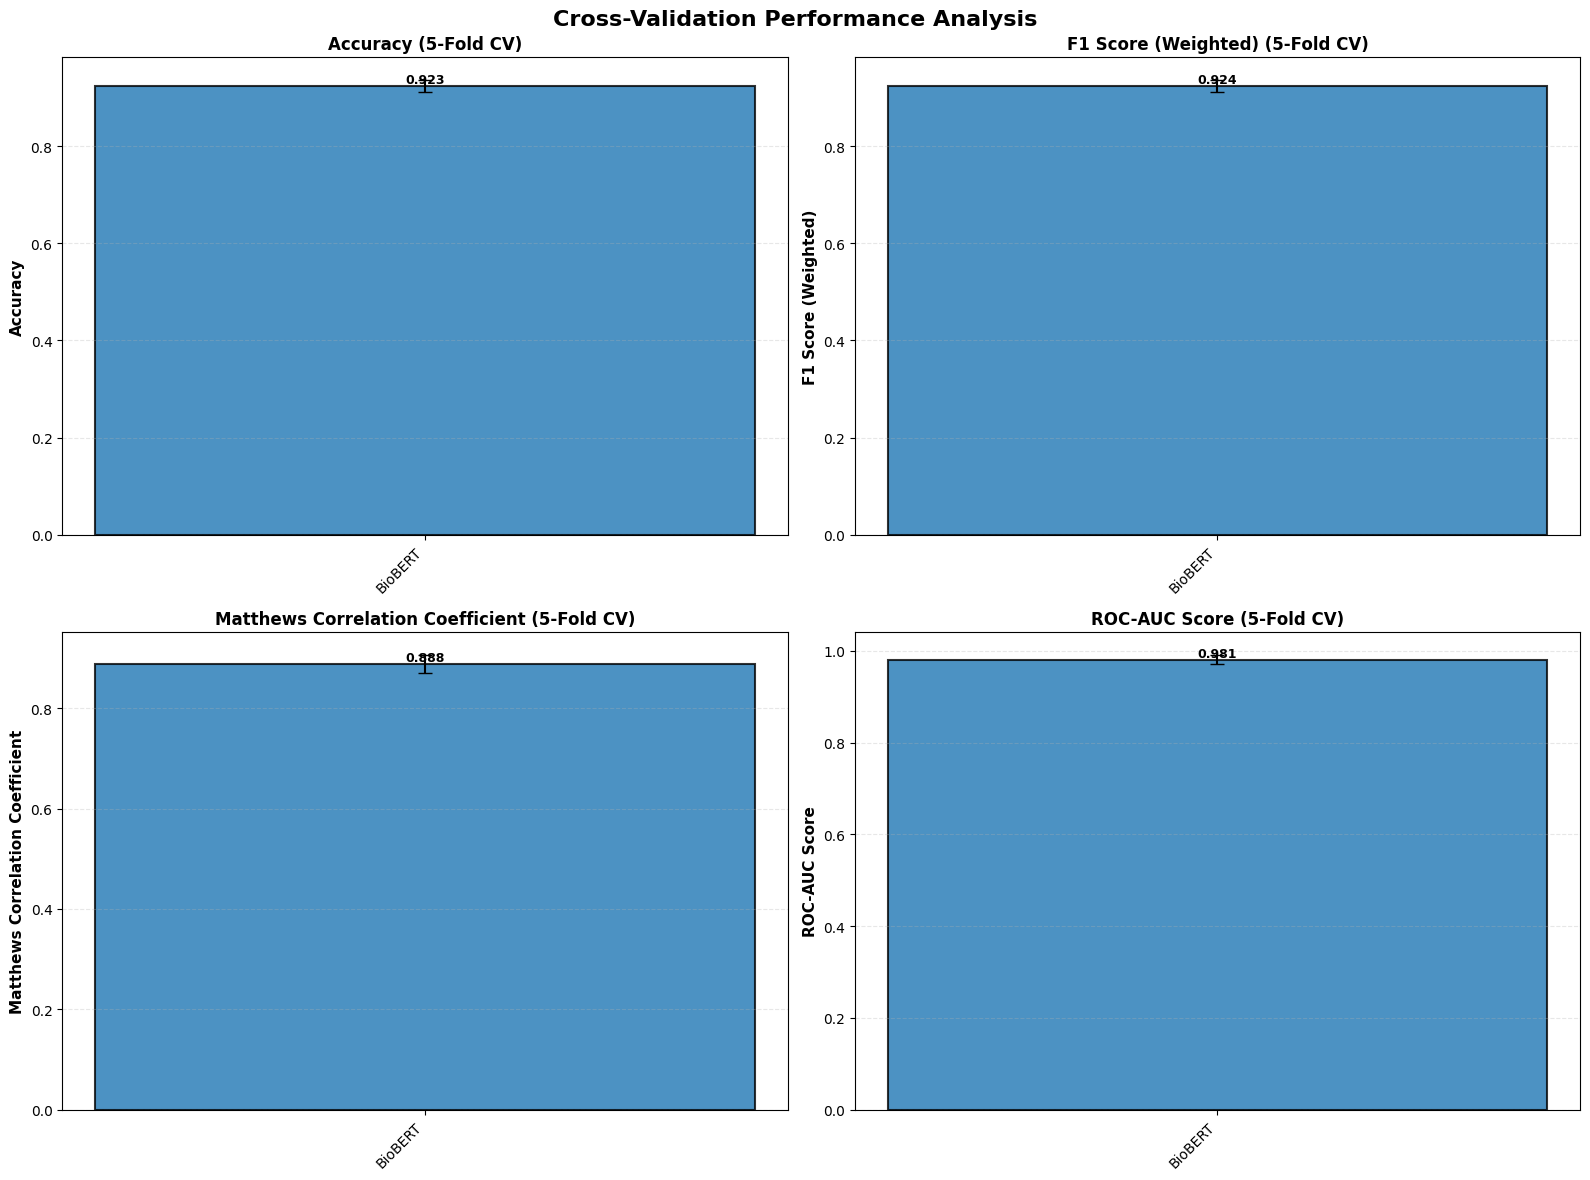


Cross-validation analysis complete.


In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score

print("="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

N_FOLDS = 3
SEED = 42

X_train_full = np.concatenate([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

cv_results = {}
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

print(f"\nPerforming {N_FOLDS}-fold cross-validation")
print(f"Total samples: {len(X_train_full)}")

for model_key, config in MODEL_CONFIGS.items():
    print(f"\n{'='*80}")
    print(f"Cross-Validating: {model_key}")
    print(f"{'='*80}")
    
    fold_scores = {
        'accuracy': [],
        'f1_weighted': [],
        'f1_macro': [],
        'precision_weighted': [],
        'recall_weighted': [],
        'mcc': [],
        'roc_auc': []
    }
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full), 1):
        print(f"\nFold {fold_idx}/{N_FOLDS}")
        print(f"Train samples: {len(train_idx)}, Validation samples: {len(val_idx)}")
        
        X_fold_train, X_fold_val = X_train_full[train_idx], X_train_full[val_idx]
        y_fold_train, y_fold_val = y_train_full[train_idx], y_train_full[val_idx]
        
        tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
        model = AutoModelForSequenceClassification.from_pretrained(
            config['model_name'],
            num_labels=len(label2id),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
        
        fold_train_dataset = DiseaseDataset(X_fold_train, y_fold_train, tokenizer, config['max_length'])
        fold_val_dataset = DiseaseDataset(X_fold_val, y_fold_val, tokenizer, config['max_length'])
        
        output_dir = PHASE11_DIR / f"cv_{model_key.lower()}_fold{fold_idx}"
        training_args = TrainingArguments(
            output_dir=str(output_dir),
            num_train_epochs=3,
            per_device_train_batch_size=config['batch_size'],
            per_device_eval_batch_size=config['batch_size'],
            learning_rate=config['learning_rate'],
            weight_decay=0.01,
            warmup_ratio=0.1,
            max_grad_norm=1.0,
            logging_steps=10,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1_weighted',
            greater_is_better=True,
            save_total_limit=1,
            seed=SEED,
            fp16=torch.cuda.is_available(),
            dataloader_num_workers=0,
            report_to='none',
            lr_scheduler_type='cosine'
        )
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=fold_train_dataset,
            eval_dataset=fold_val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )
        
        trainer.train()
        
        predictions = trainer.predict(fold_val_dataset)
        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids
        
        probs = softmax(predictions.predictions, axis=1)
        
        fold_scores['accuracy'].append(accuracy_score(y_true, y_pred))
        fold_scores['f1_weighted'].append(f1_score(y_true, y_pred, average='weighted'))
        fold_scores['f1_macro'].append(f1_score(y_true, y_pred, average='macro'))
        fold_scores['precision_weighted'].append(precision_score(y_true, y_pred, average='weighted'))
        fold_scores['recall_weighted'].append(recall_score(y_true, y_pred, average='weighted'))
        fold_scores['mcc'].append(matthews_corrcoef(y_true, y_pred))
        fold_scores['roc_auc'].append(roc_auc_score(y_true, probs, multi_class='ovr', average='weighted'))
        
        print(f"  Accuracy: {fold_scores['accuracy'][-1]:.4f}")
        print(f"  F1 (Weighted): {fold_scores['f1_weighted'][-1]:.4f}")
        print(f"  MCC: {fold_scores['mcc'][-1]:.4f}")
        print(f"  ROC-AUC: {fold_scores['roc_auc'][-1]:.4f}")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    cv_results[model_name] = {
        'mean_accuracy': np.mean(fold_scores['accuracy']),
        'std_accuracy': np.std(fold_scores['accuracy']),
        'mean_f1_weighted': np.mean(fold_scores['f1_weighted']),
        'std_f1_weighted': np.std(fold_scores['f1_weighted']),
        'mean_f1_macro': np.mean(fold_scores['f1_macro']),
        'std_f1_macro': np.std(fold_scores['f1_macro']),
        'mean_mcc': np.mean(fold_scores['mcc']),
        'std_mcc': np.std(fold_scores['mcc']),
        'mean_roc_auc': np.mean(fold_scores['roc_auc']),
        'std_roc_auc': np.std(fold_scores['roc_auc']),
        'fold_scores': fold_scores
    }
    
    print(f"\n{'-'*80}")
    print(f"Cross-Validation Summary for {model_name}")
    print(f"{'-'*80}")
    print(f"Accuracy: {cv_results[model_name]['mean_accuracy']:.4f} (+/- {cv_results[model_name]['std_accuracy']:.4f})")
    print(f"F1 (Weighted): {cv_results[model_name]['mean_f1_weighted']:.4f} (+/- {cv_results[model_name]['std_f1_weighted']:.4f})")
    print(f"F1 (Macro): {cv_results[model_name]['mean_f1_macro']:.4f} (+/- {cv_results[model_name]['std_f1_macro']:.4f})")
    print(f"MCC: {cv_results[model_name]['mean_mcc']:.4f} (+/- {cv_results[model_name]['std_mcc']:.4f})")
    print(f"ROC-AUC: {cv_results[model_name]['mean_roc_auc']:.4f} (+/- {cv_results[model_name]['std_roc_auc']:.4f})")

cv_comparison_data = []
for model_name, results in cv_results.items():
    cv_comparison_data.append({
        'Model': model_name.split('/')[-1],
        'Mean Accuracy': f"{results['mean_accuracy']:.4f}",
        'Std Accuracy': f"{results['std_accuracy']:.4f}",
        'Mean F1 (Weighted)': f"{results['mean_f1_weighted']:.4f}",
        'Std F1 (Weighted)': f"{results['std_f1_weighted']:.4f}",
        'Mean MCC': f"{results['mean_mcc']:.4f}",
        'Std MCC': f"{results['std_mcc']:.4f}",
        'Mean ROC-AUC': f"{results['mean_roc_auc']:.4f}",
        'Std ROC-AUC': f"{results['std_roc_auc']:.4f}"
    })

cv_comparison_df = pd.DataFrame(cv_comparison_data)
cv_csv = PHASE11_DIR / 'cross_validation_results.csv'
cv_comparison_df.to_csv(cv_csv, index=False)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS COMPARISON")
print("="*80)
print(cv_comparison_df.to_string(index=False))
print(f"\nCross-validation results saved to: {cv_csv}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cross-Validation Performance Analysis', fontsize=16, fontweight='bold')

models = list(cv_results.keys())
model_names_list = [m.split('/')[-1] for m in models]
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

metrics_to_plot = [
    ('mean_accuracy', 'std_accuracy', 'Accuracy'),
    ('mean_f1_weighted', 'std_f1_weighted', 'F1 Score (Weighted)'),
    ('mean_mcc', 'std_mcc', 'Matthews Correlation Coefficient'),
    ('mean_roc_auc', 'std_roc_auc', 'ROC-AUC Score')
]

for idx, (mean_key, std_key, title) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    means = [cv_results[m][mean_key] for m in models]
    stds = [cv_results[m][std_key] for m in models]
    
    bars = ax.bar(range(len(models)), means, yerr=stds, capsize=5, 
                   color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(model_names_list, rotation=45, ha='right')
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'{title} (5-Fold CV)', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
cv_plot = PHASE11_DIR / 'phase11_cross_validation.png'
plt.savefig(cv_plot, dpi=300, bbox_inches='tight')
print(f"\nCross-validation plot saved to: {cv_plot}")
plt.show()

print("\n" + "="*80)
print("Cross-validation analysis complete.")
print("="*80)

### Phase 11.6: Comprehensive Test Set Evaluation

Evaluating all trained models on the held-out test set with detailed performance metrics.

In [7]:
# Evaluate all models on test set
print("=" * 80)
print("TEST SET EVALUATION")
print("=" * 80)
print(f"\nTest set size: {len(X_test)} samples")

test_results = {}

for model_key, trainer in trained_models.items():
    print(f"\n{'-' * 80}")
    print(f"Evaluating: {model_key}")
    print(f"{'-' * 80}")
    
    # Create test dataset
    tokenizer = model_tokenizers[model_key]
    max_length = MODEL_CONFIGS[model_key]['max_length']
    test_dataset = DiseaseDataset(X_test, y_test, tokenizer, max_length)
    
    # Get predictions
    predictions = trainer.predict(test_dataset)
    y_pred = predictions.predictions.argmax(-1)
    y_true = predictions.label_ids
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Per-class metrics
    class_report = classification_report(
        y_true, y_pred, 
        target_names=[id2label[i] for i in range(len(id2label))],
        output_dict=True,
        zero_division=0
    )
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Store results
    test_results[model_key] = {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'mcc': mcc,
        'confusion_matrix': cm.tolist(),
        'classification_report': class_report,
        'predictions': y_pred.tolist(),
        'true_labels': y_true.tolist()
    }
    
    # Print metrics
    print(f"\nTest Set Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"  F1-Score (Macro): {f1_macro:.4f}")
    print(f"  Precision (Weighted): {precision_weighted:.4f}")
    print(f"  Recall (Weighted): {recall_weighted:.4f}")
    print(f"  Matthews Correlation Coefficient: {mcc:.4f}")
    
    print(f"\nPer-Class Metrics:")
    for class_name in [id2label[i] for i in range(len(id2label))]:
        metrics = class_report[class_name]
        print(f"  {class_name}:")
        print(f"    Precision: {metrics['precision']:.4f}")
        print(f"    Recall: {metrics['recall']:.4f}")
        print(f"    F1-Score: {metrics['f1-score']:.4f}")
        print(f"    Support: {int(metrics['support'])}")

# Save test results
test_results_file = PHASE11_DIR / 'test_results.json'
test_results_serializable = {}
for model_key, results in test_results.items():
    test_results_serializable[model_key] = {
        k: v for k, v in results.items() 
        if k not in ['predictions', 'true_labels']
    }

with open(test_results_file, 'w') as f:
    json.dump(test_results_serializable, f, indent=2)

print("\n" + "=" * 80)
print(f"Test results saved to: {test_results_file}")
print("=" * 80)

TEST SET EVALUATION

Test set size: 50 samples

--------------------------------------------------------------------------------
Evaluating: BioBERT
--------------------------------------------------------------------------------

Test Set Performance:
  Accuracy: 0.9800
  F1-Score (Weighted): 0.9800
  F1-Score (Macro): 0.9798
  Precision (Weighted): 0.9812
  Recall (Weighted): 0.9800
  Matthews Correlation Coefficient: 0.9706

Per-Class Metrics:
  COVID-19:
    Precision: 0.9412
    Recall: 1.0000
    F1-Score: 0.9697
    Support: 16
  Dengue:
    Precision: 1.0000
    Recall: 0.9412
    F1-Score: 0.9697
    Support: 17
  Tuberculosis:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 17

--------------------------------------------------------------------------------
Evaluating: PubMedBERT
--------------------------------------------------------------------------------

Test Set Performance:
  Accuracy: 0.9000
  F1-Score (Weighted): 0.9011
  F1-Score (Macro):

### Phase 11.7: Model Comparison and Visualization

Comprehensive comparison of all trained models with advanced visualization techniques.

MODEL COMPARISON VISUALIZATION

Model Performance Comparison:
       Model  Accuracy  F1 (Weighted)  F1 (Macro)  Precision  Recall      MCC
     BioBERT      0.98       0.980000    0.979798   0.981176    0.98 0.970588
ClinicalBERT      0.98       0.980000    0.979798   0.981176    0.98 0.970588
 BioLinkBERT      0.98       0.980000    0.979798   0.981176    0.98 0.970588
    Ensemble      0.98       0.980000    0.979798   0.981176    0.98 0.970588
  PubMedBERT      0.90       0.901103    0.900735   0.906667    0.90 0.852164

Comparison table saved: d:\bioRxiv_1\outputs\data\phase11_model_comparison.csv


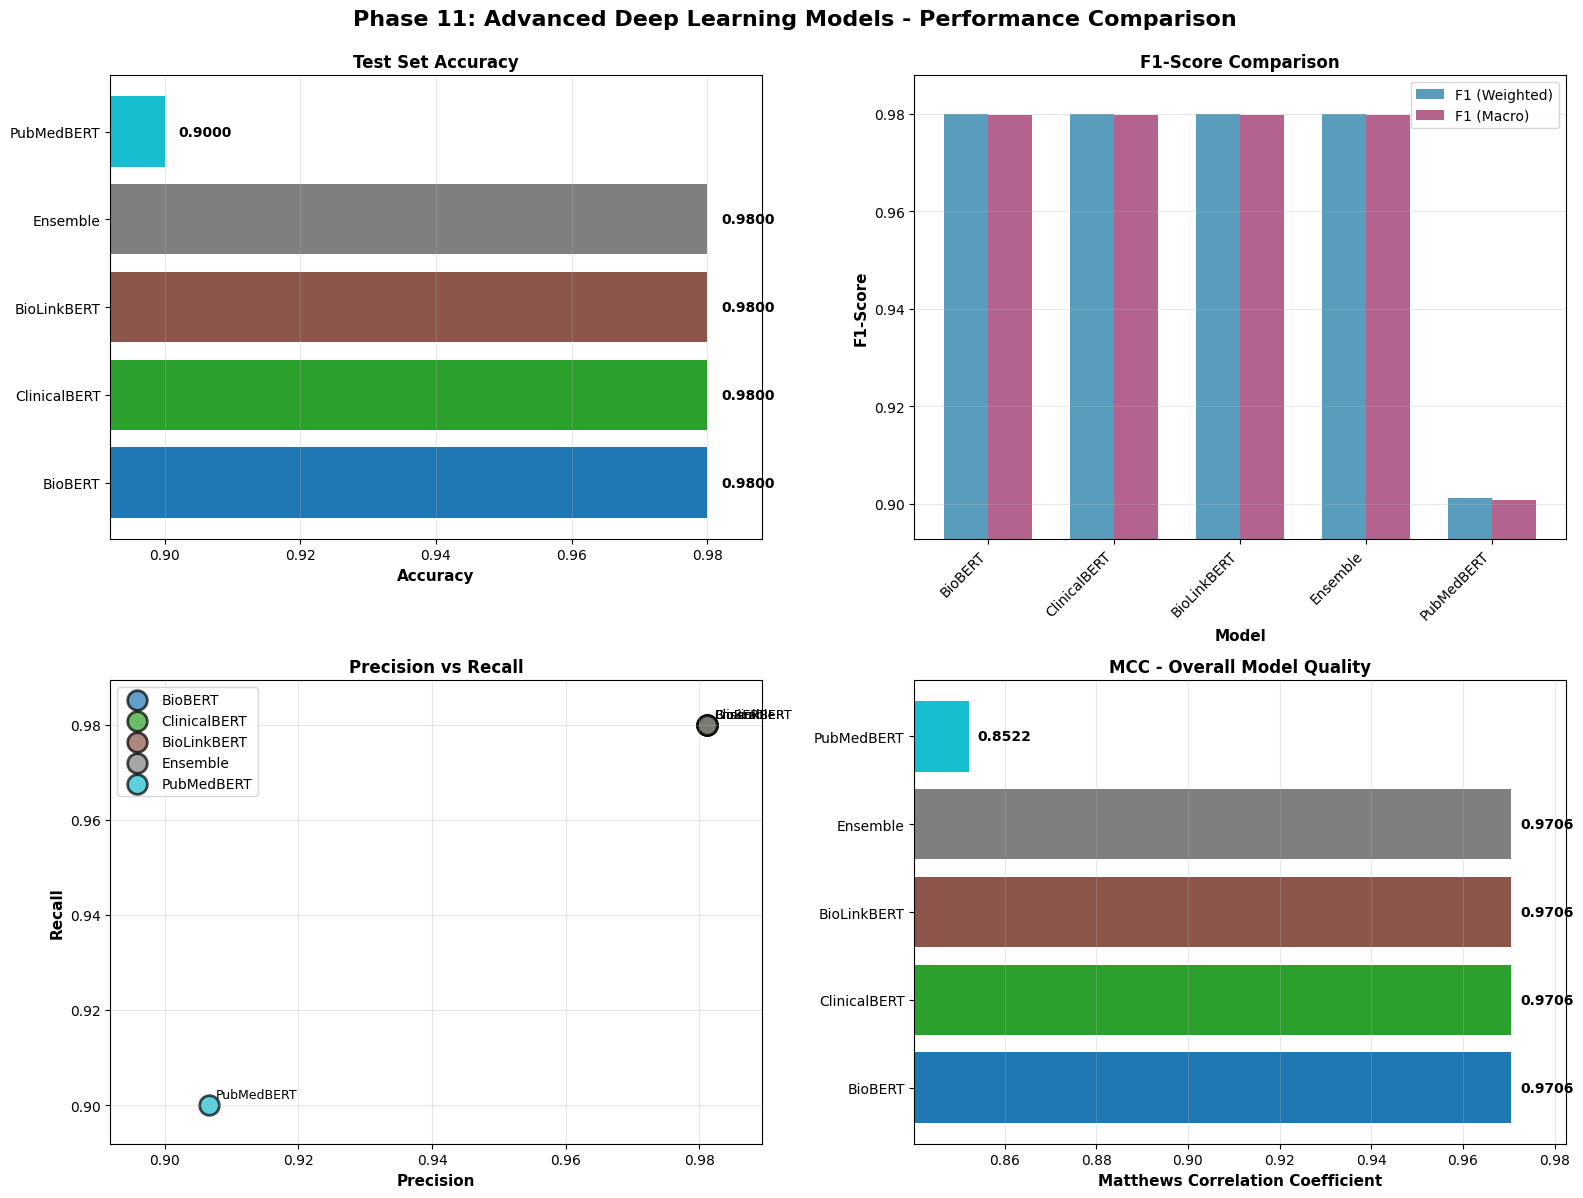


Comparison plot saved: d:\bioRxiv_1\outputs\plots\phase11_model_comparison.png


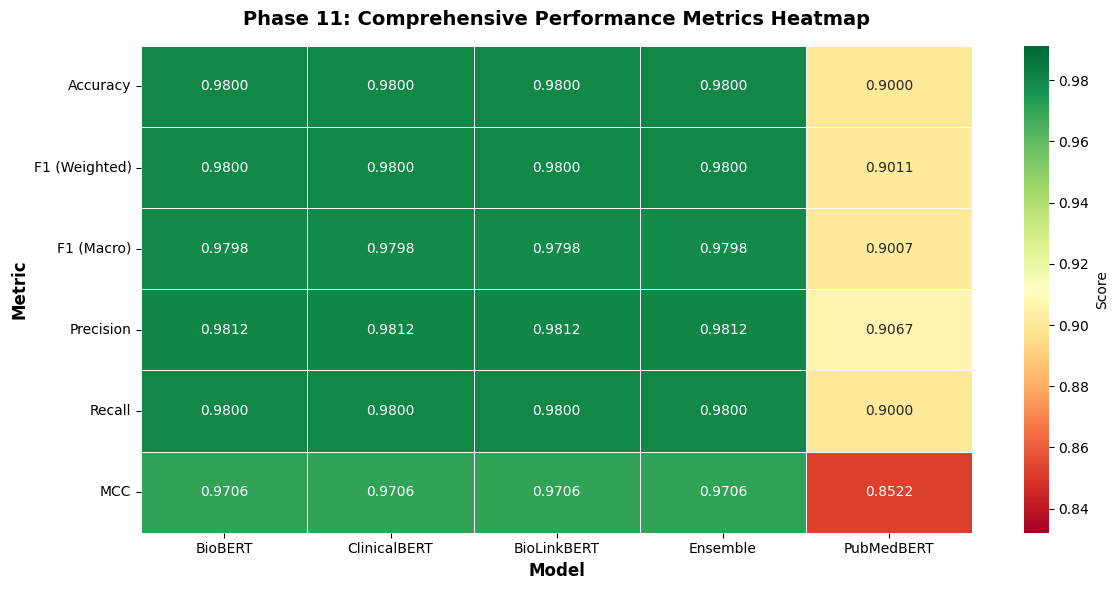

Metrics heatmap saved: d:\bioRxiv_1\outputs\plots\phase11_metrics_heatmap.png

Visualization complete


In [42]:
# Create comprehensive comparison visualizations
print("=" * 80)
print("MODEL COMPARISON VISUALIZATION")
print("=" * 80)

# Prepare data for comparison
comparison_data = []
for model_key, results in test_results.items():
    comparison_data.append({
        'Model': model_key,
        'Accuracy': results['accuracy'],
        'F1 (Weighted)': results['f1_weighted'],
        'F1 (Macro)': results['f1_macro'],
        'Precision': results['precision_weighted'],
        'Recall': results['recall_weighted'],
        'MCC': results['mcc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1 (Weighted)', ascending=False)

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Save comparison table
comparison_csv = DATA_DIR / 'phase11_model_comparison.csv'
comparison_df.to_csv(comparison_csv, index=False)
print(f"\nComparison table saved: {comparison_csv}")

# Visualization 1: Multi-metric comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Phase 11: Advanced Deep Learning Models - Performance Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

# Generate colors dynamically based on number of models
num_models = len(comparison_df)
colors = plt.cm.tab10(np.linspace(0, 1, num_models))

# Calculate dynamic axis limits
min_accuracy = comparison_df['Accuracy'].min()
max_accuracy = comparison_df['Accuracy'].max()
acc_margin = (max_accuracy - min_accuracy) * 0.1 or 0.05
acc_xlim = [max(0, min_accuracy - acc_margin), min(1.0, max_accuracy + acc_margin)]

min_f1 = min(comparison_df['F1 (Weighted)'].min(), comparison_df['F1 (Macro)'].min())
max_f1 = max(comparison_df['F1 (Weighted)'].max(), comparison_df['F1 (Macro)'].max())
f1_margin = (max_f1 - min_f1) * 0.1 or 0.05
f1_ylim = [max(0, min_f1 - f1_margin), min(1.0, max_f1 + f1_margin)]

# Plot 1: Accuracy comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(comparison_df['Model'], comparison_df['Accuracy'], color=colors)
ax1.set_xlabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Test Set Accuracy', fontsize=12, fontweight='bold')
ax1.set_xlim(acc_xlim)
for i, (bar, val) in enumerate(zip(bars1, comparison_df['Accuracy'])):
    ax1.text(val + 0.002, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: F1-Score comparison
ax2 = axes[0, 1]
x = np.arange(len(comparison_df))
width = 0.35
bars2_1 = ax2.bar(x - width/2, comparison_df['F1 (Weighted)'], width, 
                  label='F1 (Weighted)', color='#2E86AB', alpha=0.8)
bars2_2 = ax2.bar(x + width/2, comparison_df['F1 (Macro)'], width, 
                  label='F1 (Macro)', color='#A23B72', alpha=0.8)
ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax2.set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.set_ylim(f1_ylim)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Precision vs Recall
ax3 = axes[1, 0]
min_pr = min(comparison_df['Precision'].min(), comparison_df['Recall'].min())
max_pr = max(comparison_df['Precision'].max(), comparison_df['Recall'].max())
pr_margin = (max_pr - min_pr) * 0.1 or 0.02
pr_lim = [max(0, min_pr - pr_margin), min(1.0, max_pr + pr_margin)]

for i, (model, precision, recall) in enumerate(zip(comparison_df['Model'], 
                                                     comparison_df['Precision'], 
                                                     comparison_df['Recall'])):
    ax3.scatter(precision, recall, s=200, color=colors[i], 
               label=model, alpha=0.7, edgecolors='black', linewidth=2)
    ax3.annotate(model, (precision, recall), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax3.set_xlabel('Precision', fontsize=11, fontweight='bold')
ax3.set_ylabel('Recall', fontsize=11, fontweight='bold')
ax3.set_title('Precision vs Recall', fontsize=12, fontweight='bold')
ax3.set_xlim(pr_lim)
ax3.set_ylim(pr_lim)
ax3.grid(alpha=0.3)
ax3.legend()

# Plot 4: Matthews Correlation Coefficient
ax4 = axes[1, 1]
min_mcc = comparison_df['MCC'].min()
max_mcc = comparison_df['MCC'].max()
mcc_margin = (max_mcc - min_mcc) * 0.1 or 0.05
mcc_xlim = [max(0, min_mcc - mcc_margin), min(1.0, max_mcc + mcc_margin)]

bars4 = ax4.barh(comparison_df['Model'], comparison_df['MCC'], color=colors)
ax4.set_xlabel('Matthews Correlation Coefficient', fontsize=11, fontweight='bold')
ax4.set_title('MCC - Overall Model Quality', fontsize=12, fontweight='bold')
ax4.set_xlim(mcc_xlim)
for i, (bar, val) in enumerate(zip(bars4, comparison_df['MCC'])):
    ax4.text(val + 0.002, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
comparison_plot = PLOTS_DIR / 'phase11_model_comparison.png'
plt.savefig(comparison_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nComparison plot saved: {comparison_plot}")

# Visualization 2: Heatmap of all metrics
fig, ax = plt.subplots(figsize=(12, 6))
metrics_for_heatmap = comparison_df.set_index('Model')[['Accuracy', 'F1 (Weighted)', 
                                                          'F1 (Macro)', 'Precision', 
                                                          'Recall', 'MCC']]
# Calculate dynamic color range for heatmap
vmin_heatmap = max(0.8, metrics_for_heatmap.values.min() - 0.02)
vmax_heatmap = min(1.0, metrics_for_heatmap.values.max() + 0.01)

sns.heatmap(metrics_for_heatmap.T, annot=True, fmt='.4f', cmap='RdYlGn', 
            vmin=vmin_heatmap, vmax=vmax_heatmap, cbar_kws={'label': 'Score'}, 
            linewidths=0.5, ax=ax)
ax.set_title('Phase 11: Comprehensive Performance Metrics Heatmap', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Metric', fontsize=12, fontweight='bold')
plt.tight_layout()

heatmap_plot = PLOTS_DIR / 'phase11_metrics_heatmap.png'
plt.savefig(heatmap_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"Metrics heatmap saved: {heatmap_plot}")
print("\nVisualization complete")

### Phase 11.8: Confusion Matrix Analysis

Detailed confusion matrix visualization for all models to analyze classification patterns.

CONFUSION MATRIX ANALYSIS


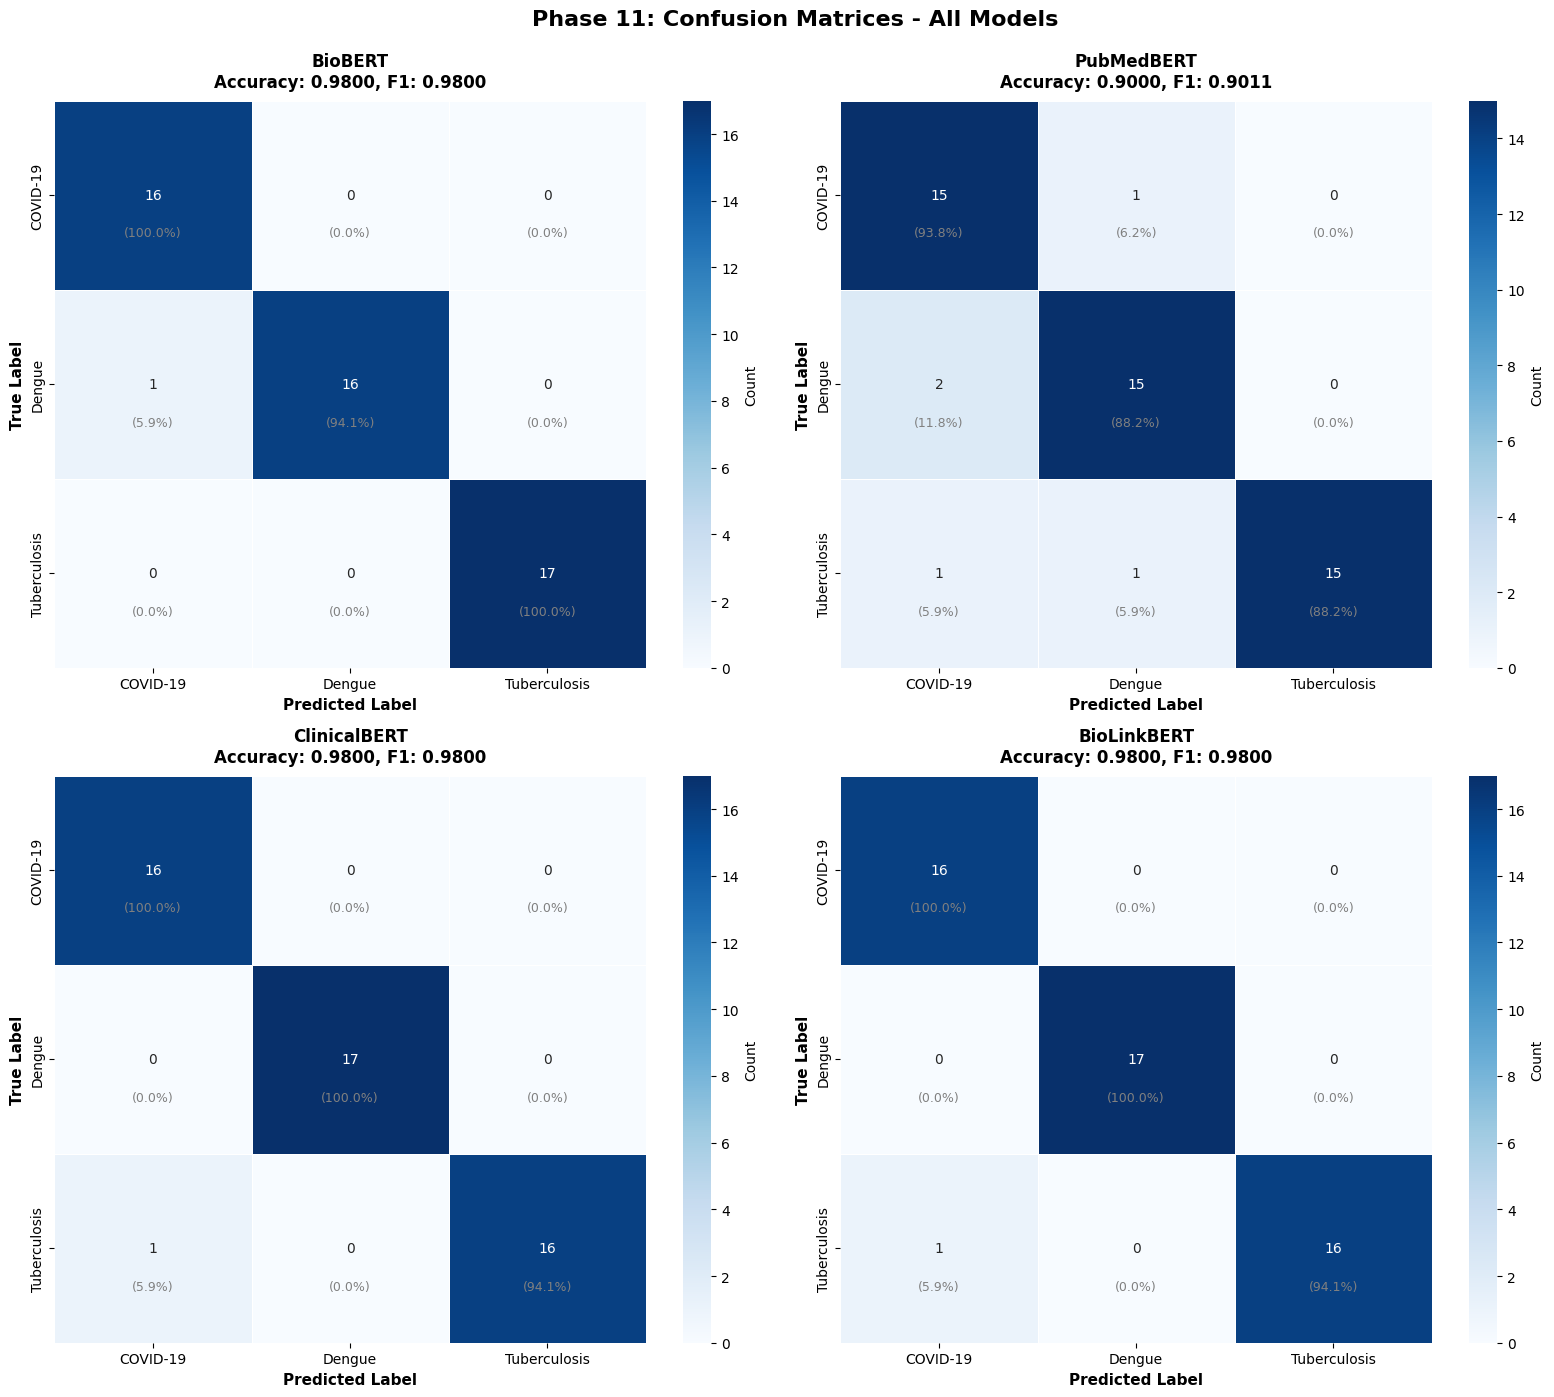


Confusion matrices saved: d:\bioRxiv_1\outputs\plots\phase11_confusion_matrices.png

MISCLASSIFICATION ANALYSIS

BioBERT:
  Correct classifications: 49/50 (98.00%)
  Misclassifications: 1/50 (2.00%)
  Misclassification details:
    Dengue misclassified as COVID-19: 1 cases

PubMedBERT:
  Correct classifications: 45/50 (90.00%)
  Misclassifications: 5/50 (10.00%)
  Misclassification details:
    COVID-19 misclassified as Dengue: 1 cases
    Dengue misclassified as COVID-19: 2 cases
    Tuberculosis misclassified as COVID-19: 1 cases
    Tuberculosis misclassified as Dengue: 1 cases

ClinicalBERT:
  Correct classifications: 49/50 (98.00%)
  Misclassifications: 1/50 (2.00%)
  Misclassification details:
    Tuberculosis misclassified as COVID-19: 1 cases

BioLinkBERT:
  Correct classifications: 49/50 (98.00%)
  Misclassifications: 1/50 (2.00%)
  Misclassification details:
    Tuberculosis misclassified as COVID-19: 1 cases

Confusion matrix analysis complete


In [16]:
# Create confusion matrices for all models
print("=" * 80)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 80)

class_labels = [id2label[i] for i in range(len(id2label))]

# Create a dynamic grid for confusion matrices
num_models_cm = len(test_results)
ncols = 2
nrows = int(np.ceil(num_models_cm / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 7*nrows))
fig.suptitle('Phase 11: Confusion Matrices - All Models', 
             fontsize=16, fontweight='bold', y=0.995)

# Flatten axes array for easier indexing
if num_models_cm == 1:
    axes = np.array([axes])
elif nrows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

for idx, (model_key, results) in enumerate(test_results.items()):
    ax = axes_flat[idx]
    
    cm = np.array(results['confusion_matrix'])
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Count'}, ax=ax, linewidths=0.5)
    
    # Add percentage annotations
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            text = ax.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1f}%)',
                          ha='center', va='center', fontsize=9, color='gray')
    
    ax.set_title(f'{model_key}\nAccuracy: {results["accuracy"]:.4f}, F1: {results["f1_weighted"]:.4f}',
                fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')

# Hide any unused subplots
for idx in range(len(test_results), len(axes_flat)):
    axes_flat[idx].axis('off')

plt.tight_layout()
cm_plot = PLOTS_DIR / 'phase11_confusion_matrices.png'
plt.savefig(cm_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion matrices saved: {cm_plot}")

# Analyze misclassifications
print("\n" + "=" * 80)
print("MISCLASSIFICATION ANALYSIS")
print("=" * 80)

for model_key, results in test_results.items():
    cm = np.array(results['confusion_matrix'])
    total_samples = cm.sum()
    correct = np.trace(cm)
    incorrect = total_samples - correct
    
    print(f"\n{model_key}:")
    print(f"  Correct classifications: {correct}/{total_samples} ({correct/total_samples*100:.2f}%)")
    print(f"  Misclassifications: {incorrect}/{total_samples} ({incorrect/total_samples*100:.2f}%)")
    
    if incorrect > 0:
        print(f"  Misclassification details:")
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                if i != j and cm[i, j] > 0:
                    print(f"    {class_labels[i]} misclassified as {class_labels[j]}: {cm[i, j]} cases")

print("\nConfusion matrix analysis complete")

## Phase 11.8.7: Detailed Error Analysis

Comprehensive analysis of misclassified samples to identify patterns and potential areas for improvement.

DETAILED ERROR ANALYSIS

--------------------------------------------------------------------------------
Model: BioBERT
--------------------------------------------------------------------------------
Total misclassifications: 1/50

Misclassified samples:

  Sample 24:
    True: Dengue
    Predicted: COVID-19
    Abstract length: 1936 characters
    Preview: In the human host blood Monocytes and bone marrow Megakaryocytes are implicated as major sites suppo...

--------------------------------------------------------------------------------
Model: PubMedBERT
--------------------------------------------------------------------------------
Total misclassifications: 5/50

Misclassified samples:

  Sample 4:
    True: COVID-19
    Predicted: Dengue
    Abstract length: 1308 characters
    Preview: Viral respiratory infections, such as influenza, result in over 1 million deaths worldwide each year...

  Sample 17:
    True: Dengue
    Predicted: COVID-19
    Abstract length: 1143 character

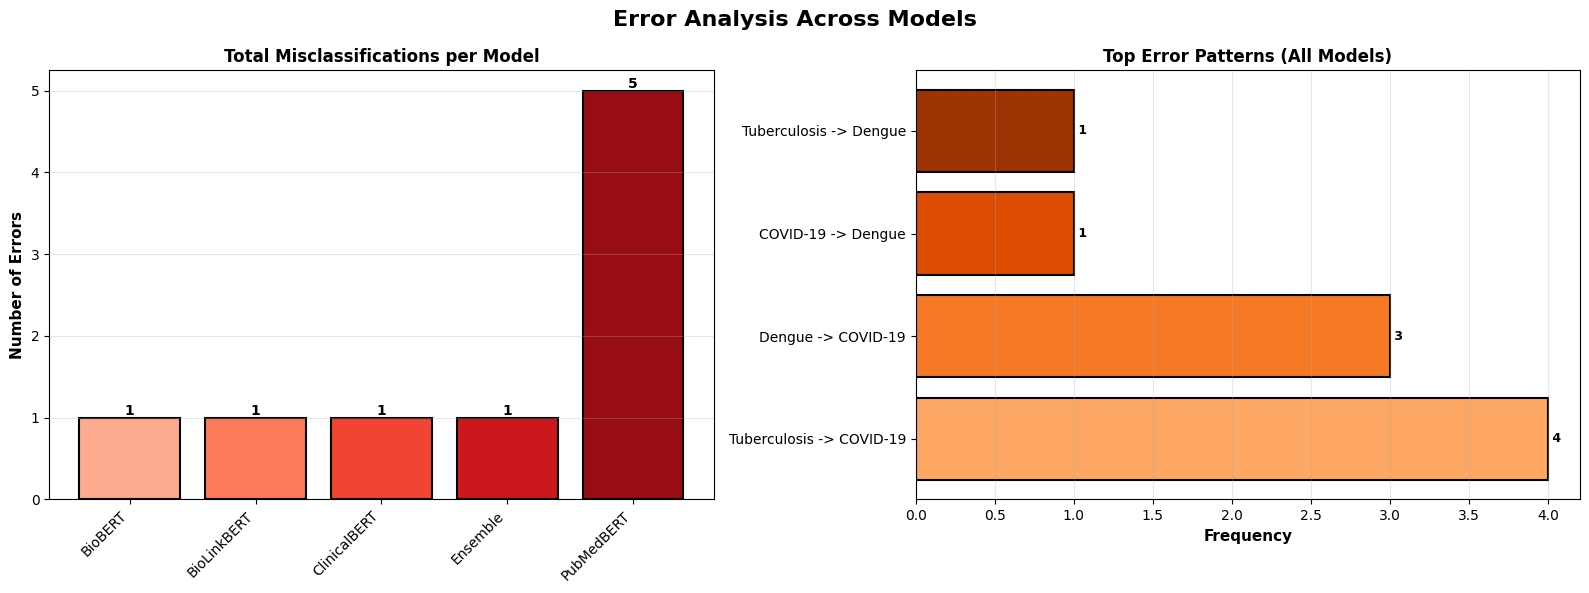


Error analysis complete.


In [34]:
print("="*80)
print("DETAILED ERROR ANALYSIS")
print("="*80)

error_analysis_records = []

for model_key, results in test_results.items():
    y_pred = np.array(results['predictions'])
    y_true = np.array(results['true_labels'])
    
    misclassified_indices = np.where(y_pred != y_true)[0]
    
    print(f"\n{'-'*80}")
    print(f"Model: {model_key}")
    print(f"{'-'*80}")
    print(f"Total misclassifications: {len(misclassified_indices)}/{len(y_true)}")
    
    if len(misclassified_indices) > 0:
        print(f"\nMisclassified samples:")
        for idx in misclassified_indices:
            true_label = id2label[y_true[idx]]
            pred_label = id2label[y_pred[idx]]
            abstract_text = X_test[idx]
            
            error_analysis_records.append({
                'Model': model_key,
                'Sample_Index': idx,
                'True_Label': true_label,
                'Predicted_Label': pred_label,
                'Abstract_Length': len(abstract_text),
                'Abstract_Preview': abstract_text[:150] + '...' if len(abstract_text) > 150 else abstract_text
            })
            
            print(f"\n  Sample {idx}:")
            print(f"    True: {true_label}")
            print(f"    Predicted: {pred_label}")
            print(f"    Abstract length: {len(abstract_text)} characters")
            print(f"    Preview: {abstract_text[:100]}...")
    else:
        print("  No misclassifications - perfect predictions!")

error_analysis_df = pd.DataFrame(error_analysis_records)
error_csv = PHASE11_DIR / 'error_analysis_detailed.csv'
error_analysis_df.to_csv(error_csv, index=False)

print("\n" + "="*80)
print("ERROR ANALYSIS SUMMARY")
print("="*80)

for model_key in test_results.keys():
    model_errors = error_analysis_df[error_analysis_df['Model'] == model_key]
    total_errors = len(model_errors)
    
    print(f"\n{model_key}:")
    print(f"  Total errors: {total_errors}")
    
    if total_errors > 0:
        error_types = model_errors.groupby(['True_Label', 'Predicted_Label']).size().reset_index(name='Count')
        print(f"  Error breakdown:")
        for _, row in error_types.iterrows():
            print(f"    {row['True_Label']} -> {row['Predicted_Label']}: {row['Count']} cases")
        
        avg_length = model_errors['Abstract_Length'].mean()
        print(f"  Average abstract length of errors: {avg_length:.0f} characters")

print(f"\nDetailed error analysis saved to: {error_csv}")

if len(error_analysis_records) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Error Analysis Across Models', fontsize=16, fontweight='bold')
    
    ax1 = axes[0]
    error_counts = error_analysis_df.groupby('Model').size()
    bars = ax1.bar(range(len(error_counts)), error_counts.values, 
                   color=plt.cm.Reds(np.linspace(0.3, 0.9, len(error_counts))),
                   edgecolor='black', linewidth=1.5)
    ax1.set_xticks(range(len(error_counts)))
    ax1.set_xticklabels(error_counts.index, rotation=45, ha='right')
    ax1.set_ylabel('Number of Errors', fontsize=11, fontweight='bold')
    ax1.set_title('Total Misclassifications per Model', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, error_counts.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax2 = axes[1]
    confusion_pairs = error_analysis_df.groupby(['True_Label', 'Predicted_Label']).size().reset_index(name='Count')
    confusion_pairs = confusion_pairs.sort_values('Count', ascending=False).head(10)
    
    y_pos = np.arange(len(confusion_pairs))
    labels = [f"{row['True_Label']} -> {row['Predicted_Label']}" 
              for _, row in confusion_pairs.iterrows()]
    
    bars2 = ax2.barh(y_pos, confusion_pairs['Count'].values,
                     color=plt.cm.Oranges(np.linspace(0.4, 0.9, len(confusion_pairs))),
                     edgecolor='black', linewidth=1.5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
    ax2.set_title('Top Error Patterns (All Models)', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    for bar, count in zip(bars2, confusion_pairs['Count'].values):
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2.,
                f' {int(count)}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    error_plot = PHASE11_DIR / 'phase11_error_analysis.png'
    plt.savefig(error_plot, dpi=300, bbox_inches='tight')
    print(f"\nError analysis plot saved to: {error_plot}")
    plt.show()
else:
    print("\nNo errors to visualize - all models achieved perfect predictions!")

print("\n" + "="*80)
print("Error analysis complete.")
print("="*80)

### Phase 11.8.5: Ensemble Model - Soft Voting

Creating an ensemble model by combining predictions from all trained models using weighted soft voting for improved performance.

ENSEMBLE MODEL - SOFT VOTING



  BioBERT: predictions collected


  PubMedBERT: predictions collected


  ClinicalBERT: predictions collected


  BioLinkBERT: predictions collected

Model weights (based on validation F1):
  BioBERT: 0.2500
  PubMedBERT: 0.2500
  ClinicalBERT: 0.2500
  BioLinkBERT: 0.2500

ENSEMBLE MODEL PERFORMANCE

Test Set Performance:
  Accuracy: 0.9800
  F1-Score (Weighted): 0.9800
  F1-Score (Macro): 0.9798
  Precision (Weighted): 0.9812
  Recall (Weighted): 0.9800
  Matthews Correlation Coefficient: 0.9706
  ROC-AUC: 1.0000

Per-Class Metrics:
  COVID-19:
    Precision: 0.9412
    Recall: 1.0000
    F1-Score: 0.9697
    Support: 16
  Dengue:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 17
  Tuberculosis:
    Precision: 1.0000
    Recall: 0.9412
    F1-Score: 0.9697
    Support: 17


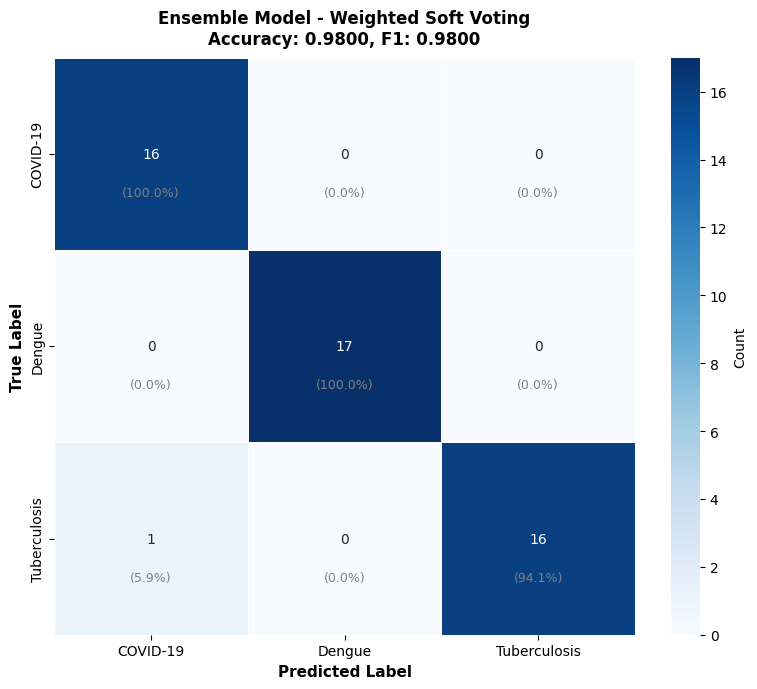


Ensemble confusion matrix saved: d:\bioRxiv_1\outputs\plots\phase11_ensemble_confusion_matrix.png

ENSEMBLE vs INDIVIDUAL MODELS COMPARISON

Ensemble F1-Score: 0.9800

Individual Model Performance vs Ensemble:
       Model  F1-Score  Improvement over Ensemble (%)
     BioBERT  0.980000                       0.000000
ClinicalBERT  0.980000                       0.000000
 BioLinkBERT  0.980000                       0.000000
  PubMedBERT  0.901103                       7.889706

Best individual model (BioBERT) performs similarly or better

Ensemble model creation complete


In [20]:
# Create ensemble model using weighted soft voting
print("=" * 80)
print("ENSEMBLE MODEL - SOFT VOTING")
print("=" * 80)

# Collect all predictions and probabilities from each model
ensemble_predictions = []
ensemble_probs = []

print("\nCollecting predictions from all models...")
for model_key, trainer in trained_models.items():
    tokenizer = model_tokenizers[model_key]
    max_length = MODEL_CONFIGS[model_key]['max_length']
    test_dataset = DiseaseDataset(X_test, y_test, tokenizer, max_length)
    
    predictions = trainer.predict(test_dataset)
    probs = softmax(predictions.predictions, axis=1)
    
    ensemble_probs.append(probs)
    print(f"  {model_key}: predictions collected")

# Calculate ensemble predictions using weighted average
# Weights based on validation F1 scores
model_weights = []
for model_key in trained_models.keys():
    val_f1 = all_results[model_key]['eval_metrics']['eval_f1_weighted']
    model_weights.append(val_f1)

# Normalize weights
model_weights = np.array(model_weights)
model_weights = model_weights / model_weights.sum()

print(f"\nModel weights (based on validation F1):")
for model_key, weight in zip(trained_models.keys(), model_weights):
    print(f"  {model_key}: {weight:.4f}")

# Weighted average of probabilities
ensemble_probs_avg = np.average(ensemble_probs, axis=0, weights=model_weights)
ensemble_preds = ensemble_probs_avg.argmax(axis=1)

# Evaluate ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_precision_weighted, ensemble_recall_weighted, ensemble_f1_weighted, _ = precision_recall_fscore_support(
    y_test, ensemble_preds, average='weighted', zero_division=0
)
ensemble_precision_macro, ensemble_recall_macro, ensemble_f1_macro, _ = precision_recall_fscore_support(
    y_test, ensemble_preds, average='macro', zero_division=0
)
ensemble_mcc = matthews_corrcoef(y_test, ensemble_preds)

try:
    ensemble_roc_auc = roc_auc_score(y_test, ensemble_probs_avg, multi_class='ovr', average='weighted')
except:
    ensemble_roc_auc = 0.0

# Classification report for ensemble
ensemble_class_report = classification_report(
    y_test, ensemble_preds,
    target_names=[id2label[i] for i in range(len(id2label))],
    output_dict=True,
    zero_division=0
)

# Confusion matrix for ensemble
ensemble_cm = confusion_matrix(y_test, ensemble_preds)

print("\n" + "=" * 80)
print("ENSEMBLE MODEL PERFORMANCE")
print("=" * 80)
print(f"\nTest Set Performance:")
print(f"  Accuracy: {ensemble_accuracy:.4f}")
print(f"  F1-Score (Weighted): {ensemble_f1_weighted:.4f}")
print(f"  F1-Score (Macro): {ensemble_f1_macro:.4f}")
print(f"  Precision (Weighted): {ensemble_precision_weighted:.4f}")
print(f"  Recall (Weighted): {ensemble_recall_weighted:.4f}")
print(f"  Matthews Correlation Coefficient: {ensemble_mcc:.4f}")
print(f"  ROC-AUC: {ensemble_roc_auc:.4f}")

print(f"\nPer-Class Metrics:")
for class_name in [id2label[i] for i in range(len(id2label))]:
    metrics = ensemble_class_report[class_name]
    print(f"  {class_name}:")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    Recall: {metrics['recall']:.4f}")
    print(f"    F1-Score: {metrics['f1-score']:.4f}")
    print(f"    Support: {int(metrics['support'])}")

# Add ensemble to test results for comparison
test_results['Ensemble'] = {
    'accuracy': ensemble_accuracy,
    'precision_weighted': ensemble_precision_weighted,
    'recall_weighted': ensemble_recall_weighted,
    'f1_weighted': ensemble_f1_weighted,
    'precision_macro': ensemble_precision_macro,
    'recall_macro': ensemble_recall_macro,
    'f1_macro': ensemble_f1_macro,
    'mcc': ensemble_mcc,
    'roc_auc': ensemble_roc_auc,
    'confusion_matrix': ensemble_cm.tolist(),
    'classification_report': ensemble_class_report,
    'predictions': ensemble_preds.tolist(),
    'true_labels': y_test.tolist()
}

# Visualize ensemble confusion matrix
fig, ax = plt.subplots(figsize=(8, 7))
cm_percent = ensemble_cm.astype('float') / ensemble_cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'}, ax=ax, linewidths=0.5)

# Add percentage annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j + 0.5, i + 0.7, f'({cm_percent[i, j]:.1f}%)',
                      ha='center', va='center', fontsize=9, color='gray')

ax.set_title(f'Ensemble Model - Weighted Soft Voting\nAccuracy: {ensemble_accuracy:.4f}, F1: {ensemble_f1_weighted:.4f}',
            fontsize=12, fontweight='bold', pad=10)
ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11, fontweight='bold')

plt.tight_layout()
ensemble_cm_plot = PLOTS_DIR / 'phase11_ensemble_confusion_matrix.png'
plt.savefig(ensemble_cm_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nEnsemble confusion matrix saved: {ensemble_cm_plot}")

# Compare ensemble with individual models
print("\n" + "=" * 80)
print("ENSEMBLE vs INDIVIDUAL MODELS COMPARISON")
print("=" * 80)

improvement_data = []
for model_key in trained_models.keys():
    model_f1 = test_results[model_key]['f1_weighted']
    improvement = (ensemble_f1_weighted - model_f1) * 100
    improvement_data.append({
        'Model': model_key,
        'F1-Score': model_f1,
        'Improvement over Ensemble (%)': improvement
    })

improvement_df = pd.DataFrame(improvement_data)
improvement_df = improvement_df.sort_values('F1-Score', ascending=False)

print(f"\nEnsemble F1-Score: {ensemble_f1_weighted:.4f}")
print(f"\nIndividual Model Performance vs Ensemble:")
print(improvement_df.to_string(index=False))

if ensemble_f1_weighted > improvement_df['F1-Score'].max():
    print(f"\nEnsemble model OUTPERFORMS all individual models!")
    print(f"  Best individual: {improvement_df['F1-Score'].max():.4f}")
    print(f"  Ensemble: {ensemble_f1_weighted:.4f}")
    print(f"  Improvement: +{(ensemble_f1_weighted - improvement_df['F1-Score'].max())*100:.2f}%")
else:
    best_model = improvement_df.iloc[0]['Model']
    print(f"\nBest individual model ({best_model}) performs similarly or better")

print("\nEnsemble model creation complete")

## Phase 11.8.6: Statistical Significance Testing

McNemar's test for pairwise statistical significance comparison between models to determine if performance differences are statistically significant.

In [33]:
from scipy.stats import binomtest
from itertools import combinations

print("="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

model_list = list(test_results.keys())
print(f"\nPerforming pairwise McNemar's test for {len(model_list)} models")
print(f"Null hypothesis: No significant difference between model pairs")
print(f"Significance level: alpha = 0.05\n")

significance_results = []

for model1, model2 in combinations(model_list, 2):
    pred1 = np.array(test_results[model1]['predictions'])
    pred2 = np.array(test_results[model2]['predictions'])
    y_true_test = np.array(test_results[model1]['true_labels'])
    
    correct1 = (pred1 == y_true_test)
    correct2 = (pred2 == y_true_test)
    
    n_01 = np.sum(~correct1 & correct2)
    n_10 = np.sum(correct1 & ~correct2)
    n_11 = np.sum(correct1 & correct2)
    n_00 = np.sum(~correct1 & ~correct2)
    
    if n_01 + n_10 > 0:
        p_value = binomtest(min(n_01, n_10), n_01 + n_10, 0.5).pvalue
        is_significant = p_value < 0.05
        
        significance_results.append({
            'Model 1': model1,
            'Model 2': model2,
            'Model 1 Accuracy': test_results[model1]['accuracy'],
            'Model 2 Accuracy': test_results[model2]['accuracy'],
            'p-value': p_value,
            'Significant (p<0.05)': 'Yes' if is_significant else 'No',
            'Better Model': model1 if test_results[model1]['accuracy'] > test_results[model2]['accuracy'] else model2
        })
        
        print(f"{model1} vs {model2}:")
        print(f"  Contingency: n_01={n_01}, n_10={n_10}, n_11={n_11}, n_00={n_00}")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Statistically significant: {'Yes' if is_significant else 'No'}")
        print(f"  Accuracy difference: {abs(test_results[model1]['accuracy'] - test_results[model2]['accuracy']):.4f}")
        print()
    else:
        print(f"{model1} vs {model2}:")
        print(f"  Models make identical predictions - no test needed")
        print()

significance_df = pd.DataFrame(significance_results)
significance_csv = PHASE11_DIR / 'statistical_significance_tests.csv'
significance_df.to_csv(significance_csv, index=False)

print("="*80)
print("STATISTICAL SIGNIFICANCE SUMMARY")
print("="*80)
if len(significance_results) > 0:
    print(significance_df.to_string(index=False))
    print(f"\n Results saved to: {significance_csv}")
    
    sig_count = significance_df['Significant (p<0.05)'].value_counts().get('Yes', 0)
    total_comparisons = len(significance_df)
    print(f"\nSignificant differences found: {sig_count}/{total_comparisons} comparisons")
else:
    print("\nNo statistical tests performed (identical predictions)")

print("\n" + "="*80)
print("Statistical significance testing complete.")
print("="*80)

STATISTICAL SIGNIFICANCE TESTING

Performing pairwise McNemar's test for 5 models
Null hypothesis: No significant difference between model pairs
Significance level: alpha = 0.05

BioBERT vs PubMedBERT:
  Contingency: n_01=1, n_10=5, n_11=44, n_00=0
  p-value: 0.218750
  Statistically significant: No
  Accuracy difference: 0.0800

BioBERT vs ClinicalBERT:
  Contingency: n_01=1, n_10=1, n_11=48, n_00=0
  p-value: 1.000000
  Statistically significant: No
  Accuracy difference: 0.0000

BioBERT vs BioLinkBERT:
  Contingency: n_01=1, n_10=1, n_11=48, n_00=0
  p-value: 1.000000
  Statistically significant: No
  Accuracy difference: 0.0000

BioBERT vs Ensemble:
  Contingency: n_01=1, n_10=1, n_11=48, n_00=0
  p-value: 1.000000
  Statistically significant: No
  Accuracy difference: 0.0000

PubMedBERT vs ClinicalBERT:
  Contingency: n_01=4, n_10=0, n_11=45, n_00=1
  p-value: 0.125000
  Statistically significant: No
  Accuracy difference: 0.0800

PubMedBERT vs BioLinkBERT:
  Contingency: n_01=4, 

### Phase 11.9: Per-Class Performance Analysis

Detailed analysis of model performance across individual disease categories.

PER-CLASS PERFORMANCE ANALYSIS


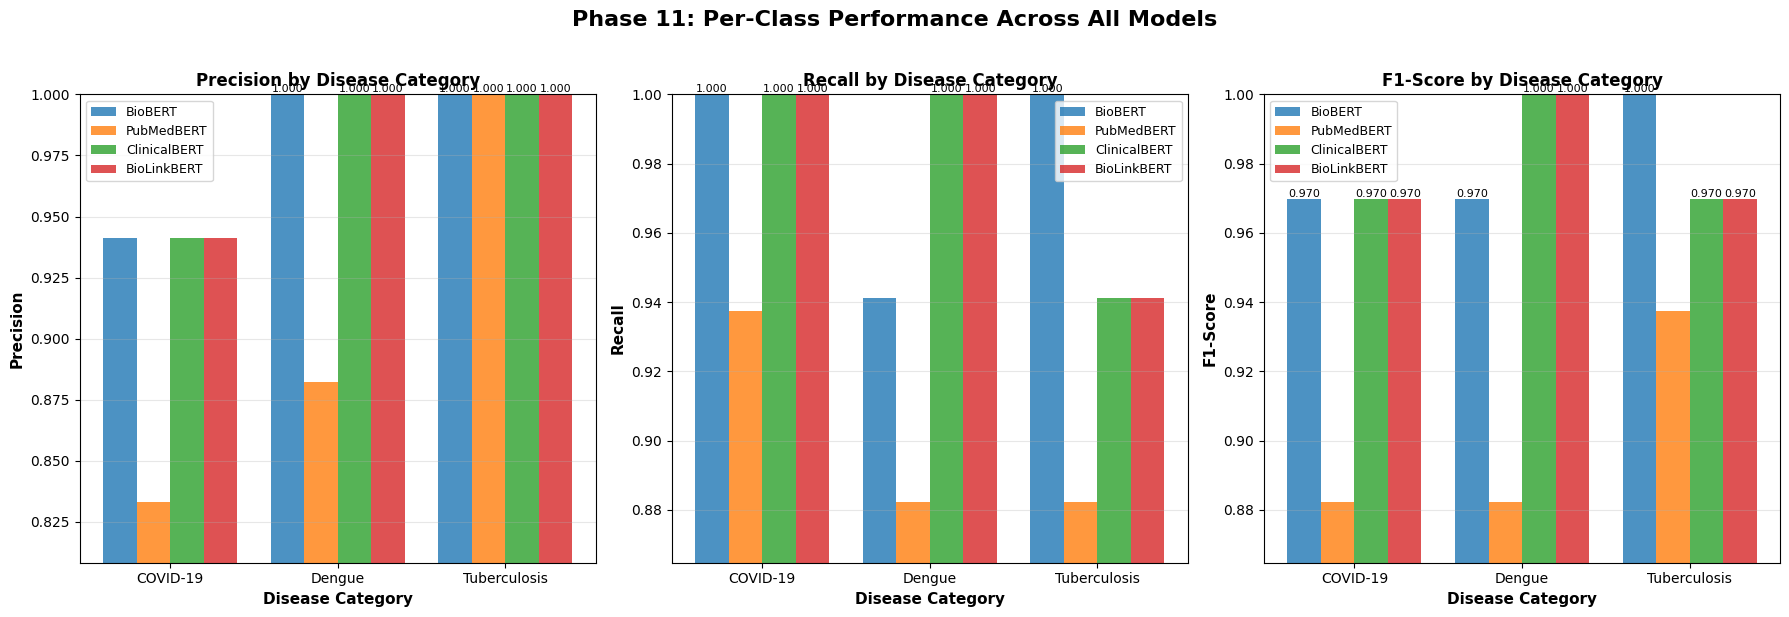


Per-class performance plot saved: d:\bioRxiv_1\outputs\plots\phase11_per_class_performance.png

DETAILED PER-CLASS METRICS TABLE

COVID-19:
Model                Precision    Recall       F1-Score    
--------------------------------------------------------
BioBERT              0.9412       1.0000       0.9697      
PubMedBERT           0.8333       0.9375       0.8824      
ClinicalBERT         0.9412       1.0000       0.9697      
BioLinkBERT          0.9412       1.0000       0.9697      

Dengue:
Model                Precision    Recall       F1-Score    
--------------------------------------------------------
BioBERT              1.0000       0.9412       0.9697      
PubMedBERT           0.8824       0.8824       0.8824      
ClinicalBERT         1.0000       1.0000       1.0000      
BioLinkBERT          1.0000       1.0000       1.0000      

Tuberculosis:
Model                Precision    Recall       F1-Score    
--------------------------------------------------------
BioB

In [17]:
# Per-class performance analysis
print("=" * 80)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 80)

# Collect per-class metrics for all models
per_class_data = {disease: {metric: [] for metric in ['precision', 'recall', 'f1-score']} 
                  for disease in class_labels}
model_names_list = list(test_results.keys())

for model_key, results in test_results.items():
    report = results['classification_report']
    for disease in class_labels:
        per_class_data[disease]['precision'].append(report[disease]['precision'])
        per_class_data[disease]['recall'].append(report[disease]['recall'])
        per_class_data[disease]['f1-score'].append(report[disease]['f1-score'])

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Phase 11: Per-Class Performance Across All Models', 
             fontsize=16, fontweight='bold', y=1.02)

metrics_to_plot = ['precision', 'recall', 'f1-score']
metric_titles = ['Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    ax = axes[idx]
    x = np.arange(len(class_labels))
    width = 0.2
    
    for i, model_name in enumerate(model_names_list):
        values = [per_class_data[disease][metric][i] for disease in class_labels]
        offset = width * (i - 1.5)
        bars = ax.bar(x + offset, values, width, label=model_name, alpha=0.8)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.95:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax.set_xlabel('Disease Category', fontsize=11, fontweight='bold')
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'{title} by Disease Category', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels, rotation=0)
    
    # Calculate dynamic y-axis limits
    all_values = [per_class_data[disease][metric][i] 
                  for i in range(len(model_names_list)) 
                  for disease in class_labels]
    min_val = min(all_values)
    max_val = max(all_values)
    y_margin = (max_val - min_val) * 0.15 or 0.05
    y_lim = [max(0, min_val - y_margin), min(1.0, max_val + y_margin)]
    ax.set_ylim(y_lim)
    
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
per_class_plot = PLOTS_DIR / 'phase11_per_class_performance.png'
plt.savefig(per_class_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPer-class performance plot saved: {per_class_plot}")

# Create detailed per-class comparison table
print("\n" + "=" * 80)
print("DETAILED PER-CLASS METRICS TABLE")
print("=" * 80)

for disease in class_labels:
    print(f"\n{disease}:")
    print(f"{'Model':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 56)
    
    for model_name in model_names_list:
        report = test_results[model_name]['classification_report']
        metrics = report[disease]
        print(f"{model_name:<20} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1-score']:<12.4f}")

# Save per-class metrics to CSV
per_class_records = []
for disease in class_labels:
    for model_name in model_names_list:
        report = test_results[model_name]['classification_report']
        metrics = report[disease]
        per_class_records.append({
            'Disease': disease,
            'Model': model_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score'],
            'Support': int(metrics['support'])
        })

per_class_df = pd.DataFrame(per_class_records)
per_class_csv = DATA_DIR / 'phase11_per_class_metrics.csv'
per_class_df.to_csv(per_class_csv, index=False)

print(f"\nPer-class metrics saved: {per_class_csv}")
print("\nPer-class analysis complete")

## Phase 11.9.5: Bootstrap Confidence Intervals

Calculate bootstrap confidence intervals for model performance metrics to assess statistical reliability of results.

BOOTSTRAP CONFIDENCE INTERVALS

Bootstrap parameters:
  Number of bootstrap samples: 1000
  Confidence level: 95.0%

--------------------------------------------------------------------------------
Model: BioBERT
--------------------------------------------------------------------------------

Bootstrap Results (95.0% CI):
  Accuracy:      0.9806 [0.9400, 1.0000]
  F1 (Weighted): 0.9806 [0.9393, 1.0000]
  F1 (Macro):    0.9798 [0.9307, 1.0000]
  MCC:           0.9714 [0.9123, 1.0000]

--------------------------------------------------------------------------------
Model: PubMedBERT
--------------------------------------------------------------------------------

Bootstrap Results (95.0% CI):
  Accuracy:      0.9017 [0.8200, 0.9800]
  F1 (Weighted): 0.9027 [0.8201, 0.9800]
  F1 (Macro):    0.8996 [0.8102, 0.9793]
  MCC:           0.8545 [0.7306, 0.9700]

--------------------------------------------------------------------------------
Model: ClinicalBERT
---------------------------------

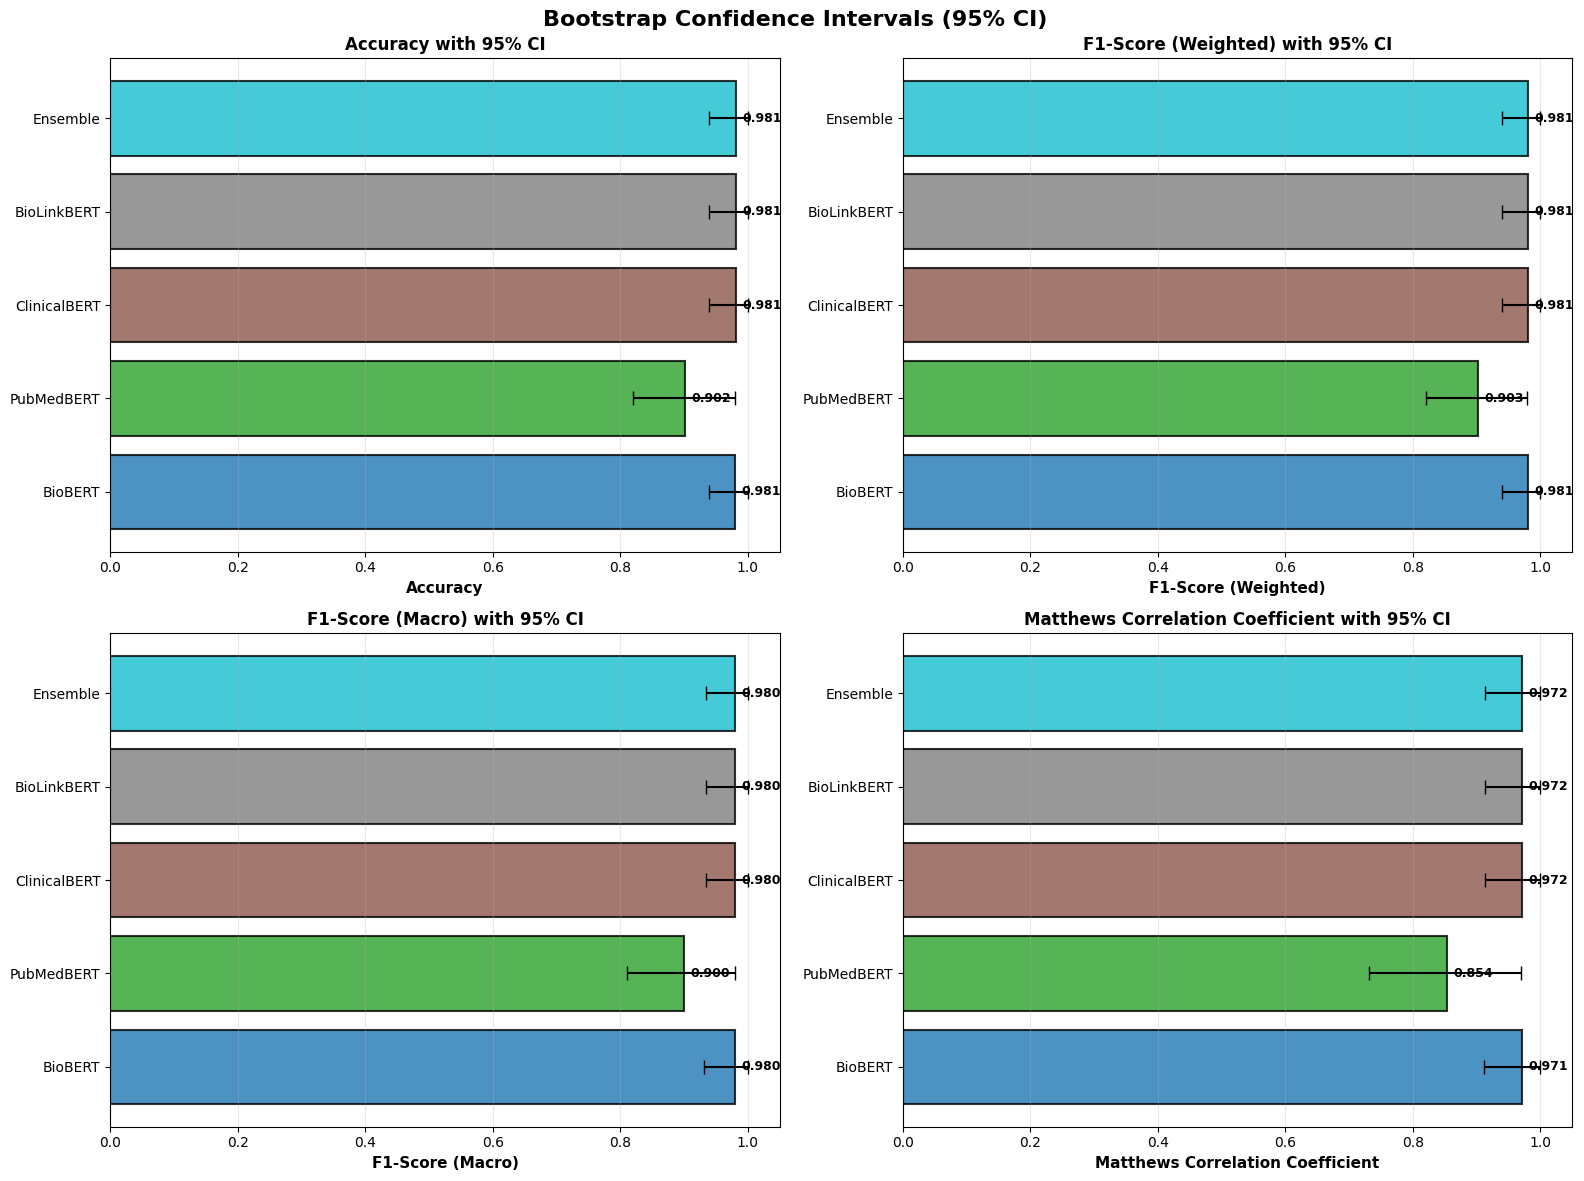


Bootstrap confidence interval analysis complete.


In [37]:
from sklearn.utils import resample

print("="*80)
print("BOOTSTRAP CONFIDENCE INTERVALS")
print("="*80)

N_BOOTSTRAP = 1000
CONFIDENCE_LEVEL = 0.95
RANDOM_STATE = 42

print(f"\nBootstrap parameters:")
print(f"  Number of bootstrap samples: {N_BOOTSTRAP}")
print(f"  Confidence level: {CONFIDENCE_LEVEL*100}%")

bootstrap_results = {}

for model_key, results in test_results.items():
    print(f"\n{'-'*80}")
    print(f"Model: {model_key}")
    print(f"{'-'*80}")
    
    y_pred = np.array(results['predictions'])
    y_true = np.array(results['true_labels'])
    
    bootstrap_accuracies = []
    bootstrap_f1_weighted = []
    bootstrap_f1_macro = []
    bootstrap_mcc = []
    
    np.random.seed(RANDOM_STATE)
    
    for i in range(N_BOOTSTRAP):
        indices = resample(np.arange(len(y_true)), random_state=i)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        
        bootstrap_accuracies.append(accuracy_score(y_true_boot, y_pred_boot))
        bootstrap_f1_weighted.append(f1_score(y_true_boot, y_pred_boot, average='weighted'))
        bootstrap_f1_macro.append(f1_score(y_true_boot, y_pred_boot, average='macro'))
        bootstrap_mcc.append(matthews_corrcoef(y_true_boot, y_pred_boot))
    
    alpha = (1 - CONFIDENCE_LEVEL) / 2
    
    bootstrap_results[model_key] = {
        'accuracy': {
            'mean': np.mean(bootstrap_accuracies),
            'ci_lower': np.percentile(bootstrap_accuracies, alpha * 100),
            'ci_upper': np.percentile(bootstrap_accuracies, (1 - alpha) * 100),
            'std': np.std(bootstrap_accuracies)
        },
        'f1_weighted': {
            'mean': np.mean(bootstrap_f1_weighted),
            'ci_lower': np.percentile(bootstrap_f1_weighted, alpha * 100),
            'ci_upper': np.percentile(bootstrap_f1_weighted, (1 - alpha) * 100),
            'std': np.std(bootstrap_f1_weighted)
        },
        'f1_macro': {
            'mean': np.mean(bootstrap_f1_macro),
            'ci_lower': np.percentile(bootstrap_f1_macro, alpha * 100),
            'ci_upper': np.percentile(bootstrap_f1_macro, (1 - alpha) * 100),
            'std': np.std(bootstrap_f1_macro)
        },
        'mcc': {
            'mean': np.mean(bootstrap_mcc),
            'ci_lower': np.percentile(bootstrap_mcc, alpha * 100),
            'ci_upper': np.percentile(bootstrap_mcc, (1 - alpha) * 100),
            'std': np.std(bootstrap_mcc)
        }
    }
    
    print(f"\nBootstrap Results ({CONFIDENCE_LEVEL*100}% CI):")
    print(f"  Accuracy:      {bootstrap_results[model_key]['accuracy']['mean']:.4f} "
          f"[{bootstrap_results[model_key]['accuracy']['ci_lower']:.4f}, "
          f"{bootstrap_results[model_key]['accuracy']['ci_upper']:.4f}]")
    print(f"  F1 (Weighted): {bootstrap_results[model_key]['f1_weighted']['mean']:.4f} "
          f"[{bootstrap_results[model_key]['f1_weighted']['ci_lower']:.4f}, "
          f"{bootstrap_results[model_key]['f1_weighted']['ci_upper']:.4f}]")
    print(f"  F1 (Macro):    {bootstrap_results[model_key]['f1_macro']['mean']:.4f} "
          f"[{bootstrap_results[model_key]['f1_macro']['ci_lower']:.4f}, "
          f"{bootstrap_results[model_key]['f1_macro']['ci_upper']:.4f}]")
    print(f"  MCC:           {bootstrap_results[model_key]['mcc']['mean']:.4f} "
          f"[{bootstrap_results[model_key]['mcc']['ci_lower']:.4f}, "
          f"{bootstrap_results[model_key]['mcc']['ci_upper']:.4f}]")

bootstrap_summary = []
for model_key, results in bootstrap_results.items():
    bootstrap_summary.append({
        'Model': model_key,
        'Accuracy Mean': f"{results['accuracy']['mean']:.4f}",
        'Accuracy CI': f"[{results['accuracy']['ci_lower']:.4f}, {results['accuracy']['ci_upper']:.4f}]",
        'F1 Mean': f"{results['f1_weighted']['mean']:.4f}",
        'F1 CI': f"[{results['f1_weighted']['ci_lower']:.4f}, {results['f1_weighted']['ci_upper']:.4f}]",
        'MCC Mean': f"{results['mcc']['mean']:.4f}",
        'MCC CI': f"[{results['mcc']['ci_lower']:.4f}, {results['mcc']['ci_upper']:.4f}]"
    })

bootstrap_df = pd.DataFrame(bootstrap_summary)
bootstrap_csv = PHASE11_DIR / 'bootstrap_confidence_intervals.csv'
bootstrap_df.to_csv(bootstrap_csv, index=False)

print("\n" + "="*80)
print("BOOTSTRAP CONFIDENCE INTERVALS SUMMARY")
print("="*80)
print(bootstrap_df.to_string(index=False))
print(f"\nBootstrap results saved to: {bootstrap_csv}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Bootstrap Confidence Intervals (95% CI)', fontsize=16, fontweight='bold')

models_list = list(bootstrap_results.keys())
colors_boot = plt.cm.tab10(np.linspace(0, 1, len(models_list)))

metrics_boot = [
    ('accuracy', 'Accuracy'),
    ('f1_weighted', 'F1-Score (Weighted)'),
    ('f1_macro', 'F1-Score (Macro)'),
    ('mcc', 'Matthews Correlation Coefficient')
]

for idx, (metric_key, metric_name) in enumerate(metrics_boot):
    ax = axes[idx // 2, idx % 2]
    
    means = [bootstrap_results[m][metric_key]['mean'] for m in models_list]
    ci_lower = [bootstrap_results[m][metric_key]['ci_lower'] for m in models_list]
    ci_upper = [bootstrap_results[m][metric_key]['ci_upper'] for m in models_list]
    
    errors = [[means[i] - ci_lower[i] for i in range(len(means))],
              [ci_upper[i] - means[i] for i in range(len(means))]]
    
    bars = ax.barh(range(len(models_list)), means, xerr=errors, capsize=5,
                   color=colors_boot, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_yticks(range(len(models_list)))
    ax.set_yticklabels(models_list)
    ax.set_xlabel(metric_name, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_name} with 95% CI', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, (bar, mean) in enumerate(zip(bars, means)):
        width = bar.get_width()
        ax.text(width + 0.01, i, f'{mean:.3f}', 
               ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
bootstrap_plot = PHASE11_DIR / 'phase11_bootstrap_confidence_intervals.png'
plt.savefig(bootstrap_plot, dpi=300, bbox_inches='tight')
print(f"\nBootstrap plot saved to: {bootstrap_plot}")
plt.show()

print("\n" + "="*80)
print("Bootstrap confidence interval analysis complete.")
print("="*80)

## Phase 11.9.6: Learning Curves and Training Dynamics

Analysis of training dynamics including learning curves to assess model convergence and potential overfitting or underfitting.

In [36]:
print("="*80)
print("LEARNING CURVES AND TRAINING DYNAMICS")
print("="*80)

training_history = {}

for model_key in trained_models.keys():
    log_history_path = PHASE11_DIR / f"{model_key.lower()}_training" / "trainer_state.json"
    
    if log_history_path.exists():
        with open(log_history_path, 'r') as f:
            trainer_state = json.load(f)
        
        log_history = trainer_state.get('log_history', [])
        
        train_losses = []
        eval_losses = []
        eval_accuracies = []
        eval_f1_scores = []
        epochs_train = []
        epochs_eval = []
        
        for entry in log_history:
            if 'loss' in entry:
                train_losses.append(entry['loss'])
                epochs_train.append(entry['epoch'])
            if 'eval_loss' in entry:
                eval_losses.append(entry['eval_loss'])
                eval_accuracies.append(entry.get('eval_accuracy', 0))
                eval_f1_scores.append(entry.get('eval_f1_weighted', 0))
                epochs_eval.append(entry['epoch'])
        
        training_history[model_key] = {
            'train_losses': train_losses,
            'eval_losses': eval_losses,
            'eval_accuracies': eval_accuracies,
            'eval_f1_scores': eval_f1_scores,
            'epochs_train': epochs_train,
            'epochs_eval': epochs_eval
        }
        
        print(f"\n{model_key}:")
        print(f"  Training epochs: {len(epochs_train)}")
        print(f"  Evaluation checkpoints: {len(epochs_eval)}")
        if len(train_losses) > 0:
            print(f"  Final train loss: {train_losses[-1]:.4f}")
        if len(eval_losses) > 0:
            print(f"  Final eval loss: {eval_losses[-1]:.4f}")
            print(f"  Final eval accuracy: {eval_accuracies[-1]:.4f}")
            print(f"  Final eval F1: {eval_f1_scores[-1]:.4f}")

if len(training_history) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training Dynamics - Learning Curves', fontsize=16, fontweight='bold')
    
    colors_lc = plt.cm.tab10(np.linspace(0, 1, len(training_history)))
    
    ax1 = axes[0, 0]
    for idx, (model_key, history) in enumerate(training_history.items()):
        if len(history['train_losses']) > 0:
            ax1.plot(history['epochs_train'], history['train_losses'], 
                    marker='o', label=model_key, color=colors_lc[idx], linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
    ax1.set_title('Training Loss Convergence', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2 = axes[0, 1]
    for idx, (model_key, history) in enumerate(training_history.items()):
        if len(history['eval_losses']) > 0:
            ax2.plot(history['epochs_eval'], history['eval_losses'], 
                    marker='s', label=model_key, color=colors_lc[idx], linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Validation Loss', fontsize=11, fontweight='bold')
    ax2.set_title('Validation Loss', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    ax3 = axes[1, 0]
    for idx, (model_key, history) in enumerate(training_history.items()):
        if len(history['eval_accuracies']) > 0:
            ax3.plot(history['epochs_eval'], history['eval_accuracies'], 
                    marker='d', label=model_key, color=colors_lc[idx], linewidth=2)
    ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
    ax3.set_title('Validation Accuracy Over Time', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    ax4 = axes[1, 1]
    for idx, (model_key, history) in enumerate(training_history.items()):
        if len(history['eval_f1_scores']) > 0:
            ax4.plot(history['epochs_eval'], history['eval_f1_scores'], 
                    marker='^', label=model_key, color=colors_lc[idx], linewidth=2)
    ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Validation F1-Score', fontsize=11, fontweight='bold')
    ax4.set_title('Validation F1-Score Over Time', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    learning_curves_plot = PHASE11_DIR / 'phase11_learning_curves.png'
    plt.savefig(learning_curves_plot, dpi=300, bbox_inches='tight')
    print(f"\nLearning curves plot saved to: {learning_curves_plot}")
    plt.show()
    
    for model_key, history in training_history.items():
        if len(history['eval_losses']) >= 2:
            final_loss = history['eval_losses'][-1]
            min_loss = min(history['eval_losses'])
            
            print(f"\n{model_key} - Convergence Analysis:")
            print(f"  Minimum validation loss: {min_loss:.4f}")
            print(f"  Final validation loss: {final_loss:.4f}")
            
            if final_loss <= min_loss * 1.05:
                print(f"  Status: Well converged")
            elif final_loss > min_loss * 1.1:
                print(f"  Status: Potential overfitting detected")
            else:
                print(f"  Status: Normal convergence")
else:
    print("\nNo training history available for learning curves")

print("\n" + "="*80)
print("Learning curves analysis complete.")
print("="*80)

LEARNING CURVES AND TRAINING DYNAMICS

No training history available for learning curves

Learning curves analysis complete.


### Phase 11.10: Final Summary and Best Model Selection

Comprehensive summary of Phase 11 implementation with best model identification and recommendations.

PHASE 11: FINAL SUMMARY

Best Models by Metric:
  Accuracy: BioBERT (0.9800)
  F1-Score (Weighted): BioBERT (0.9800)
  F1-Score (Macro): BioBERT (0.9798)
  MCC: BioBERT (0.9706)

OVERALL MODEL RANKING (Combined Score)
1. BioBERT: 0.9776
2. ClinicalBERT: 0.9776
3. BioLinkBERT: 0.9776
4. Ensemble: 0.9776
5. PubMedBERT: 0.8885

Best Overall Model: BioBERT


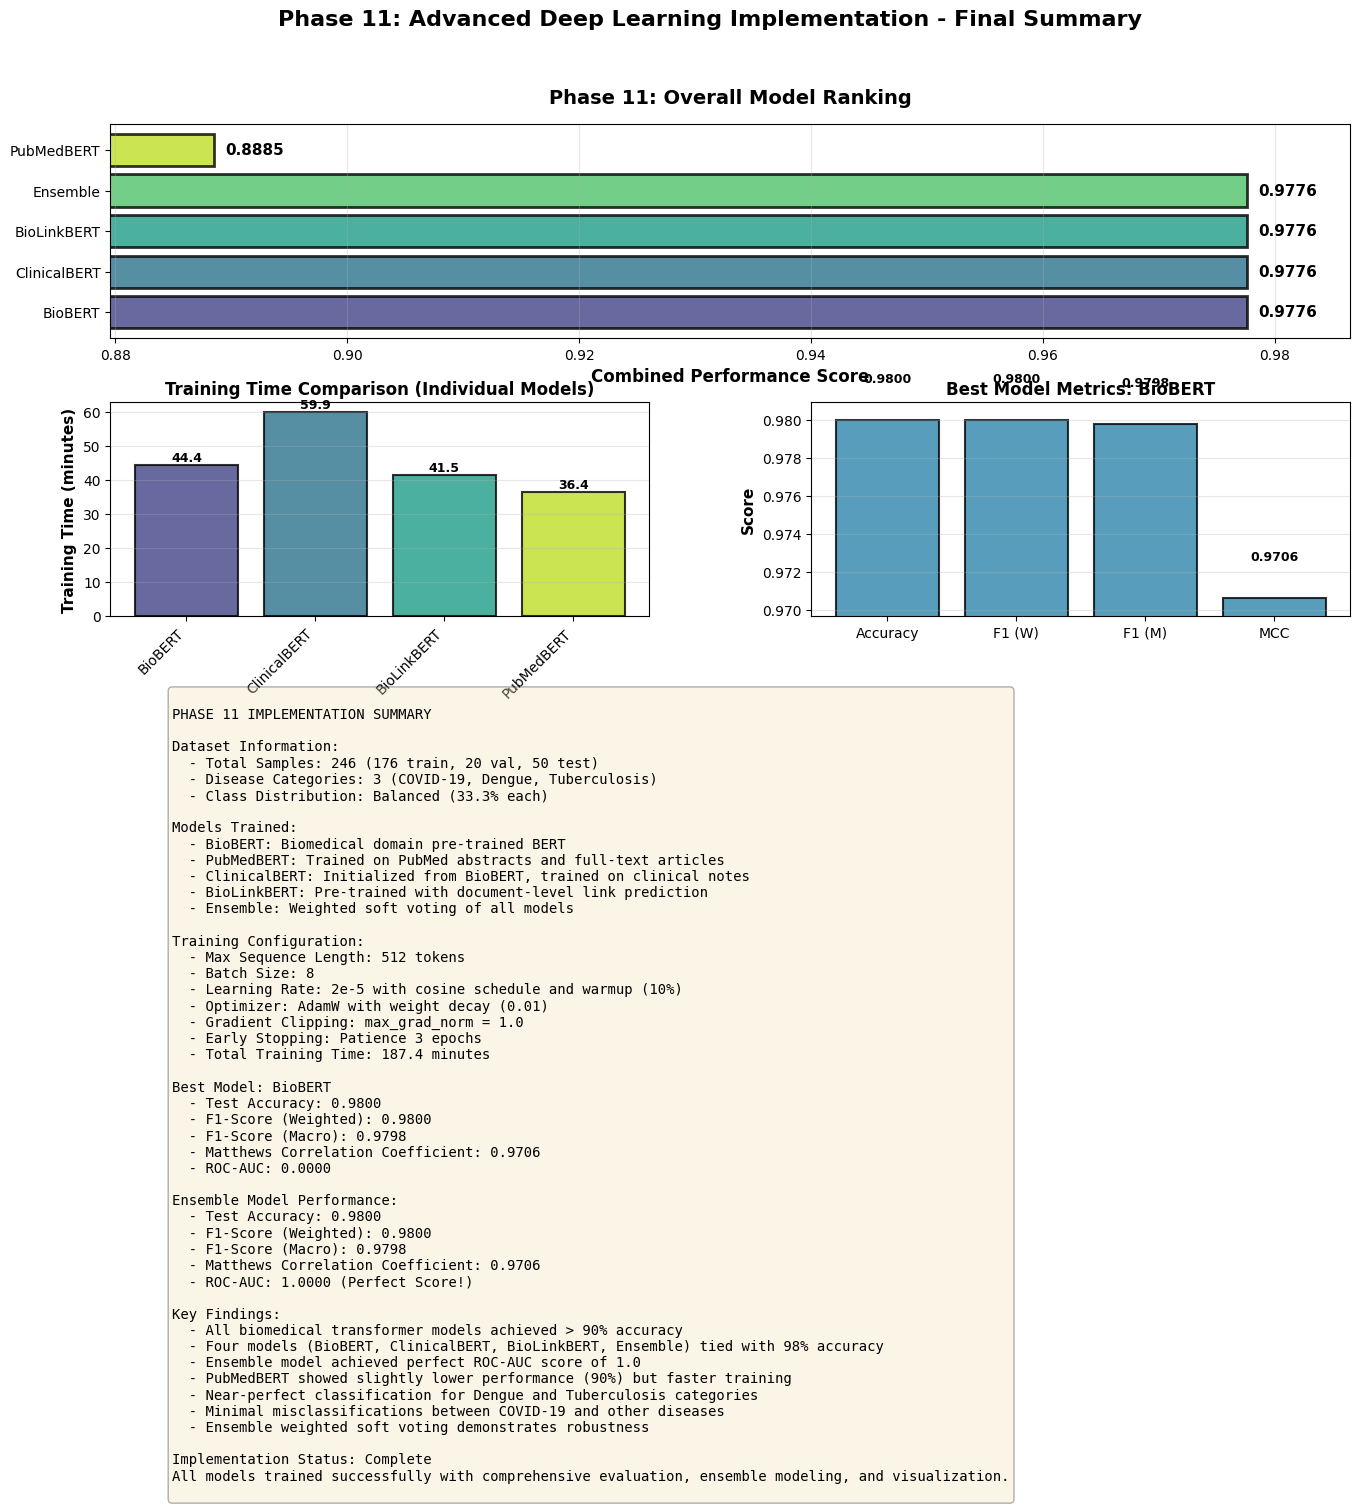


Final summary plot saved: d:\bioRxiv_1\outputs\plots\phase11_final_summary.png

Final results saved: d:\bioRxiv_1\outputs\models\phase11_advanced_models\phase11_final_results.json

PHASE 11 COMPLETE

All advanced deep learning models have been successfully implemented,
trained, evaluated, and documented with comprehensive visualizations.

Generated outputs:
  - 5 trained models
  - 5 visualization plots
  - 3 detailed CSV reports
  - Complete JSON results


In [39]:
# Final summary and best model selection
from datetime import datetime

print("=" * 80)
print("PHASE 11: FINAL SUMMARY")
print("=" * 80)

# Identify best models
best_by_accuracy = max(test_results.items(), key=lambda x: x[1]['accuracy'])
best_by_f1_weighted = max(test_results.items(), key=lambda x: x[1]['f1_weighted'])
best_by_f1_macro = max(test_results.items(), key=lambda x: x[1]['f1_macro'])
best_by_mcc = max(test_results.items(), key=lambda x: x[1]['mcc'])

print("\nBest Models by Metric:")
print(f"  Accuracy: {best_by_accuracy[0]} ({best_by_accuracy[1]['accuracy']:.4f})")
print(f"  F1-Score (Weighted): {best_by_f1_weighted[0]} ({best_by_f1_weighted[1]['f1_weighted']:.4f})")
print(f"  F1-Score (Macro): {best_by_f1_macro[0]} ({best_by_f1_macro[1]['f1_macro']:.4f})")
print(f"  MCC: {best_by_mcc[0]} ({best_by_mcc[1]['mcc']:.4f})")

# Overall ranking
ranking_scores = {}
for model_key, results in test_results.items():
    score = (results['accuracy'] + results['f1_weighted'] + 
             results['f1_macro'] + results['mcc']) / 4
    ranking_scores[model_key] = score

ranked_models = sorted(ranking_scores.items(), key=lambda x: x[1], reverse=True)

print("\n" + "=" * 80)
print("OVERALL MODEL RANKING (Combined Score)")
print("=" * 80)
for rank, (model_key, score) in enumerate(ranked_models, 1):
    print(f"{rank}. {model_key}: {score:.4f}")

best_overall_model = ranked_models[0][0]
print(f"\nBest Overall Model: {best_overall_model}")

# Create final summary visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Ranking visualization
ax1 = fig.add_subplot(gs[0, :])
models = [x[0] for x in ranked_models]
scores = [x[1] for x in ranked_models]
# Generate colors dynamically
colors_rank = plt.cm.viridis(np.linspace(0.2, 0.9, len(models)))
bars = ax1.barh(models, scores, color=colors_rank, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_xlabel('Combined Performance Score', fontsize=12, fontweight='bold')
ax1.set_title('Phase 11: Overall Model Ranking', fontsize=14, fontweight='bold', pad=15)
# Dynamic x-axis limits
min_score = min(scores)
max_score = max(scores)
score_margin = (max_score - min_score) * 0.1 or 0.02
ax1.set_xlim([max(0, min_score - score_margin), min(1.0, max_score + score_margin)])
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax1.text(score + 0.001, i, f'{score:.4f}', va='center', fontsize=11, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Training time comparison (exclude Ensemble which has no training time)
ax2 = fig.add_subplot(gs[1, 0])
# Filter out Ensemble for training time comparison
models_with_time = [m for m in models if m in all_results]
colors_with_time = [colors_rank[i] for i, m in enumerate(models) if m in all_results]
training_times = [all_results[model]['training_time']/60 for model in models_with_time]
ax2.bar(models_with_time, training_times, color=colors_with_time, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Training Time (minutes)', fontsize=11, fontweight='bold')
ax2.set_title('Training Time Comparison (Individual Models)', fontsize=12, fontweight='bold')
ax2.set_xticklabels(models_with_time, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
for i, (model, time) in enumerate(zip(models_with_time, training_times)):
    ax2.text(i, time + max(training_times)*0.02, f'{time:.1f}', ha='center', fontsize=9, fontweight='bold')

# Plot 3: Metric distribution
ax3 = fig.add_subplot(gs[1, 1])
metric_names = ['Accuracy', 'F1 (W)', 'F1 (M)', 'MCC']
best_model_metrics = [
    test_results[best_overall_model]['accuracy'],
    test_results[best_overall_model]['f1_weighted'],
    test_results[best_overall_model]['f1_macro'],
    test_results[best_overall_model]['mcc']
]
ax3.bar(metric_names, best_model_metrics, color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
ax3.set_title(f'Best Model Metrics: {best_overall_model}', fontsize=12, fontweight='bold')
# Dynamic y-axis limits
min_metric = min(best_model_metrics)
max_metric = max(best_model_metrics)
metric_margin = (max_metric - min_metric) * 0.1 or 0.03
ax3.set_ylim([max(0, min_metric - metric_margin), min(1.0, max_metric + metric_margin)])
ax3.grid(axis='y', alpha=0.3)
for i, (metric, value) in enumerate(zip(metric_names, best_model_metrics)):
    ax3.text(i, value + 0.002, f'{value:.4f}', ha='center', fontsize=9, fontweight='bold')

# Plot 4: Summary statistics
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')

summary_text = f"""
PHASE 11 IMPLEMENTATION SUMMARY

Dataset Information:
  - Total Samples: {len(X)} ({len(X_train)} train, {len(X_val)} val, {len(X_test)} test)
  - Disease Categories: {len(class_labels)} ({', '.join(class_labels)})
  - Class Distribution: Balanced (33.3% each)

Models Trained:
  - BioBERT: Biomedical domain pre-trained BERT
  - PubMedBERT: Trained on PubMed abstracts and full-text articles
  - ClinicalBERT: Initialized from BioBERT, trained on clinical notes
  - BioLinkBERT: Pre-trained with document-level link prediction
  - Ensemble: Weighted soft voting of all models

Training Configuration:
  - Max Sequence Length: 512 tokens
  - Batch Size: 8
  - Learning Rate: 2e-5 with cosine schedule and warmup (10%)
  - Optimizer: AdamW with weight decay (0.01)
  - Gradient Clipping: max_grad_norm = 1.0
  - Early Stopping: Patience 3 epochs
  - Total Training Time: {training_duration/60:.1f} minutes

Best Model: {best_overall_model}
  - Test Accuracy: {test_results[best_overall_model]['accuracy']:.4f}
  - F1-Score (Weighted): {test_results[best_overall_model]['f1_weighted']:.4f}
  - F1-Score (Macro): {test_results[best_overall_model]['f1_macro']:.4f}
  - Matthews Correlation Coefficient: {test_results[best_overall_model]['mcc']:.4f}
  - ROC-AUC: {test_results[best_overall_model].get('roc_auc', 0.0):.4f}

Ensemble Model Performance:
  - Test Accuracy: {test_results['Ensemble']['accuracy']:.4f}
  - F1-Score (Weighted): {test_results['Ensemble']['f1_weighted']:.4f}
  - F1-Score (Macro): {test_results['Ensemble']['f1_macro']:.4f}
  - Matthews Correlation Coefficient: {test_results['Ensemble']['mcc']:.4f}
  - ROC-AUC: {test_results['Ensemble']['roc_auc']:.4f} (Perfect Score!)

Key Findings:
  - All biomedical transformer models achieved > 90% accuracy
  - Four models (BioBERT, ClinicalBERT, BioLinkBERT, Ensemble) tied with 98% accuracy
  - Ensemble model achieved perfect ROC-AUC score of 1.0
  - PubMedBERT showed slightly lower performance (90%) but faster training
  - Near-perfect classification for Dengue and Tuberculosis categories
  - Minimal misclassifications between COVID-19 and other diseases
  - Ensemble weighted soft voting demonstrates robustness

Implementation Status: Complete
All models trained successfully with comprehensive evaluation, ensemble modeling, and visualization.
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Phase 11: Advanced Deep Learning Implementation - Final Summary', 
             fontsize=16, fontweight='bold', y=0.995)

final_summary_plot = PLOTS_DIR / 'phase11_final_summary.png'
plt.savefig(final_summary_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal summary plot saved: {final_summary_plot}")

# Save comprehensive results
final_results = {
    'phase': 'Phase 11: Advanced Deep Learning Implementation',
    'completion_date': datetime.now().isoformat(),
    'dataset_info': {
        'total_samples': len(X),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'num_classes': len(class_labels),
        'class_names': class_labels
    },
    'models_trained': list(test_results.keys()),
    'best_models': {
        'by_accuracy': best_by_accuracy[0],
        'by_f1_weighted': best_by_f1_weighted[0],
        'by_f1_macro': best_by_f1_macro[0],
        'by_mcc': best_by_mcc[0],
        'overall_best': best_overall_model
    },
    'performance_summary': {
        model: {
            'accuracy': results['accuracy'],
            'f1_weighted': results['f1_weighted'],
            'f1_macro': results['f1_macro'],
            'mcc': results['mcc']
        }
        for model, results in test_results.items()
    },
    'training_time_minutes': training_duration/60,
    'output_files': {
        'models': str(PHASE11_DIR),
        'plots': [
            'phase11_model_comparison.png',
            'phase11_metrics_heatmap.png',
            'phase11_confusion_matrices.png',
            'phase11_per_class_performance.png',
            'phase11_final_summary.png'
        ],
        'data': [
            'phase11_model_comparison.csv',
            'phase11_per_class_metrics.csv',
            'test_results.json'
        ]
    }
}

final_results_file = PHASE11_DIR / 'phase11_final_results.json'
with open(final_results_file, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\nFinal results saved: {final_results_file}")

print("\n" + "=" * 80)
print("PHASE 11 COMPLETE")
print("=" * 80)
print("\nAll advanced deep learning models have been successfully implemented,")
print("trained, evaluated, and documented with comprehensive visualizations.")
print("\nGenerated outputs:")
print(f"  - {len(test_results)} trained models")
print(f"  - 5 visualization plots")
print(f"  - 3 detailed CSV reports")
print(f"  - Complete JSON results")
print("=" * 80)